# MISO Illinois Hub Pricing Tool






In [1]:
#Username and password for YES Energy DSAPI 
import my_secrets
username=my_secrets.username
password=my_secrets.password

#import required libraries
import pandas as pd
import numpy as np
import requests # Establishes connection to DSAPI to get data
import datetime
from datetime import datetime, timedelta, date 
import holidays

#modeling
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.preprocessing import QuantileTransformer,StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid, GridSearchCV
import xgboost 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# testing 
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

#visualizations
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import matplotlib.patches as mpatches
import seaborn as sns


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

### Helper Functions

In [3]:
def peak(hour):
    '''Maps hour-ending value (1-24) to peaktype'''
    if hour >= 11 and hour <= 17:
        return "SUPER"
    elif (hour >=7 and hour <11)or(hour >17 and hour <=19):
        return "ON"
    else: 
        return "OFF"

def encode(data, col, max_val):
    '''Encodes categorical column as periodic sin/cos function'''
    data[col + '_sin'] = np.sin(2 * np.pi * data[col].astype('category').cat.codes/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col].astype('category').cat.codes/max_val)
    return data


In [4]:
def makelags(s,lag=[1,25]):
    '''Return dataframe with lag columns for lag amounts defined by lag list'''
    new_dict={}
    for col_name in s:
        for l in lag:
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)
    return res.dropna()


In [5]:
def transform(x,df, var='RTLMP'):
    '''Return the log transformed version of dataframe column x, deal with negative values by translate entire column up by the minimum price.'''
    return np.log(x+1-min(df[var]))

def inverse_transform(x,df, var='RTLMP'):
    '''Inverse transformation of transform(x) function gets you back your original column values.'''
    return np.exp(x)-1+min(df[var])

In [6]:
def find_spikes(df,lag=24, thresh=3.5, influence=0.5):
    ''' See: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data
    This function locates real time spikes in the RTLMP variable
    '''
    filteredY=df.RTLMP.iloc[:lag+1]
    df['PEAK']=0
    avgFilter=filteredY.mean()
    stdFilter=filteredY.std()

    for i in range(lag+1,len(df.RTLMP)):
        if (abs(df.RTLMP[i]-avgFilter)>thresh*stdFilter):
            if df.RTLMP[i]>avgFilter:
                df.PEAK[i]=1
            else:
                df.PEAK[i]=-1
            filteredY.at[i]=(influence * df.RTLMP[i]) + ((1-influence)*filteredY[i-1])
        else:
            df.PEAK[i]=0
            filteredY.at[i]=df.RTLMP[i]
      
        avgFilter=filteredY.iloc[i-lag+1:i].mean()
        stdFilter=filteredY.iloc[i-lag+1:i].std()

def find_spikes_dalmp(df,lag=24, thresh=3.5, influence=0.5):
    '''This is a refined version of find_spikes that uses the DALMP as a basis for spike definition'''
    filteredY=df.DALMP[:lag+1]
    df['PEAK']=0
    avgFilter=filteredY.mean()
    stdFilter=filteredY.std()

    for i in range(lag+1,len(df.RTLMP)):
        if (abs(df.RTLMP[i]-avgFilter)>thresh*stdFilter):
            if df.RTLMP[i]>avgFilter:
                df.PEAK[i]=1
            else:
                df.PEAK[i]=-1
            filteredY.at[i]=(influence * df.DALMP[i]) + ((1-influence)*filteredY[i-1])
        else:
            df.PEAK[i]=0
            filteredY.at[i]=df.DALMP[i]
      
        avgFilter=filteredY[i-lag+1:i].mean()
        stdFilter=filteredY[i-lag+1:i].std()


def find_spikes_fast(df, lag=24, thresh=3.5):
    '''This is a faster version of find_spikes with loop removed. This function does not contain the influence variable. '''
    df['avgFilter'] = df.RTLMP.rolling(lag, closed="left").mean()
    df['stdFilter'] = df.RTLMP.rolling(lag, closed="left").std()
    df['pos_peak'] = df.RTLMP - df.avgFilter.shift(1) > thresh * df.stdFilter.shift(1)
    df['neg_peak'] = (abs(df.avgFilter.shift(1) - df.RTLMP) >  thresh * df.stdFilter.shift(1)) & (df.avgFilter.shift(1)>df.RTLMP)
  
    df['PEAK'] = df.pos_peak.astype(int) - df.neg_peak.astype(int)
    df.drop(['avgFilter', 'stdFilter', 'pos_peak', 'neg_peak'], axis=1, inplace=True)


In [7]:
def plot_fill(dt, flag, fill_color='red'):
    '''Fill plot vertically for hours with flag==1'''
    if flag==1:
        ax.axvspan(xmin=dt, xmax=dt+timedelta(hours=1),  facecolor=fill_color, alpha=0.15)


In [8]:
def df_preprocessing(df, backtest=False):
    '''Apply data pre-processing to raw table from YESEnergy and return modified dataframe'''
    #Remove rows with NaN datetimes from the dataframe
    df.dropna(axis=0, subset=['DATETIME'], inplace=True)
    df.drop_duplicates(subset=['DATETIME'], inplace=True)
    #Convert datetime column to datetime object
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])

    # Rename some columns for convenience
    df.rename(columns={'ILLINOIS.HUB (RTLMP)': 'RTLMP',
                     'ILLINOIS.HUB (DALMP)': 'DALMP',
                     'IL - Springfield/Capital (WSI_TRADER_PRCP)': 'WSI_TRADER_PRCP',
                     'IL - Springfield/Capital (WSI_TRADER_CLDC)': 'WSI_TRADER_CLDC',
                     'IL - Springfield/Capital (WSI_TRADER_TEMP)': 'WSI_TRADER_TEMP',
                     'IL - Springfield/Capital (WSI_TRADER_WIND)': 'WSI_TRADER_WIND',
                     'IL - Springfield/Capital (WSI_TRADER_RH)': 'WSI_TRADER_RH',
                     'IL - Springfield/Capital (WSI_FC15_TEMP)':'WSI_FC15_TEMP',
                     'IL - Springfield/Capital (WSI_FC15_PRCP)': 'WSI_FC15_PRCP',
                     'IL - Springfield/Capital (WSI_FC15_RH)':'WSI_FC15_RH',
                     'IL - Springfield/Capital (WSI_FC15_CLDC)':'WSI_FC15_CLDC',
                     'IL - Springfield/Capital (WSI_FC15_WIND)':'WSI_FC15_WIND', 
                     'Central (FC_CAP_ON_OUTAGE)' : 'FC_CAP_ON_OUTAGE',
                     'Central (MISO_MTD_SOLAR_FC_ORG)' : 'MISO_MTD_SOLAR_FC_ORG',
                     'Central (REG_DERATE_GEN_OFFLINE_CAPACITY)':'GEN_OFFLINE_CAPACITY'},
                   inplace = True)
   
    #make holiday flag column
    us_holidays=[]
    for holiday_date in holidays.US(years=np.arange(2018,2023)).items():
        us_holidays.append(str(holiday_date[0]))
    df['US Holiday']=[1 if (str(val).split()[0] in us_holidays) else 0 for val in df['DATETIME']]
   
    # Make weekend flag column
    df['Weekend'] = [1 if val.weekday()>=5 else 0 for val in df['DATETIME']]
    #OR weekend and holiday columns
    df["WEEKEND/HOLIDAY"] = 0
    df["WEEKEND/HOLIDAY"] =(df["Weekend"] | df["US Holiday"])
    #drop weekend and holiday columns
    df=df.drop(['Weekend','US Holiday'],axis=1) 
   
    #OFFPEAK: HE 19-7, ONPEAK: HE 7-11, HE 17-19, SUPERPEAK: HE 11-17
    df.HOURENDING=df.HOURENDING.astype(int)
    df['PEAKTYPE'] = df.apply(lambda row: peak(row['HOURENDING']), axis=1)
   
    #create a column with the season
    season_dict = {'JANUARY': 'Winter',
                'FEBRUARY': 'Winter',
                'MARCH': 'Spring', 
                'APRIL': 'Spring',
                'MAY': 'Spring',
                'JUNE': 'Summer',
                'JULY': 'Summer',
                'AUGUST': 'Summer',
                'SEPTEMBER': 'Fall',
                'OCTOBER': 'Fall',
                'NOVEMBER': 'Fall',
                'DECEMBER': 'Winter'}
    df['SEASON'] = df['MONTH'].apply(lambda x: season_dict[x])
    df['WEEKDAY']=pd.to_datetime(df['DATETIME']).dt.day_name()
    
    #Create cyclical encoding for calendar variables
    df = encode(df, 'HOURENDING', 24)
    df = encode(df, 'PEAKTYPE', 3)
    df = encode(df, 'SEASON', 4)
    df = encode(df, 'WEEKDAY', 7)
    df = encode(df, 'MONTH', 12)
    df=df.drop(['HOURENDING', 'MARKETDAY','PEAKTYPE'],axis=1) #drop columns after encoding them

    # replace NA values with 0 for CAPOFF features i.e. assume that if the offline capacity is NaN, there is no offline capacity
    df["FC_CAP_ON_OUTAGE"] = df["FC_CAP_ON_OUTAGE"].fillna(0)
    df["MISO_MTD_SOLAR_FC_ORG"] = df["MISO_MTD_SOLAR_FC_ORG"].fillna(0)
    df["GEN_OFFLINE_CAPACITY"] = df["GEN_OFFLINE_CAPACITY"].fillna(0)

    #drop categorical columns that have been encoded
    df=df.drop(['MONTH', 'YEAR', 'SEASON', 'WEEKDAY'],axis=1)
    
    if backtest==True:
        df['DA_MW']=df['DA_MW'].fillna(0)
        df['PREVIOUS_DAY_FORECAST_VOLUME']=df['PREVIOUS_DAY_FORECAST_VOLUME'].fillna(0)
        df['GENERATION_MW']=df['GENERATION_MW'].fillna(0)
  
  
    df= df.reset_index(drop=True)
    return df

In [9]:
def prepare_forecast(df):
    '''Function replaces relevant features with their forecasts in df.'''
    df=df.reset_index(drop=True)
  
    df['Central (RTLOAD)'].fillna(df['Central (LOAD_FORECAST)'], inplace=True)   
    df['WSI_TRADER_TEMP'].fillna(df['WSI_FC15_TEMP'], inplace=True)
    df['WSI_TRADER_PRCP'].fillna(df['WSI_FC15_PRCP'], inplace=True)
    df['WSI_TRADER_CLDC'].fillna(df['WSI_FC15_CLDC'], inplace=True)
    df['WSI_TRADER_RH'].fillna(df['WSI_FC15_RH'], inplace=True)
    df['WSI_TRADER_WIND'].fillna(df['WSI_FC15_WIND'], inplace=True)


    df=df.reset_index(drop=True)
    return df

### Demonstrating Model Performance for a Sample Week

In [8]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:10000000602,DALMP:10000000602,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text) 

In [17]:
df=df_preprocessing(dfs[0])

In [19]:
df=prepare_forecast(df)

In [21]:
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)

In [25]:
find_spikes_dalmp(df,lag=6,thresh=2.5,influence=0.25)

In [28]:
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)

In [29]:
df.reset_index(drop=True, inplace=True) 

In [30]:
#split into train and test
X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['DALMP'],df,'DALMP')  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)

In [31]:
#We will make regression predictions for the DALMP 

xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df,'DALMP')

rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df,'DALMP')

lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df, 'DALMP')


[11:44:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
#Classify real time spikes 

clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)

In [33]:
#Assemble results into dataframe

d={ "West Hub XGB PRICES": y_pred, 
    "West Hub rf Prices": y_pred_rf,
    "West Hub lm Prices": y_pred_lm,
    "Actuals": inverse_transform(y_test,df, 'DALMP'),
    "Spikes":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1)

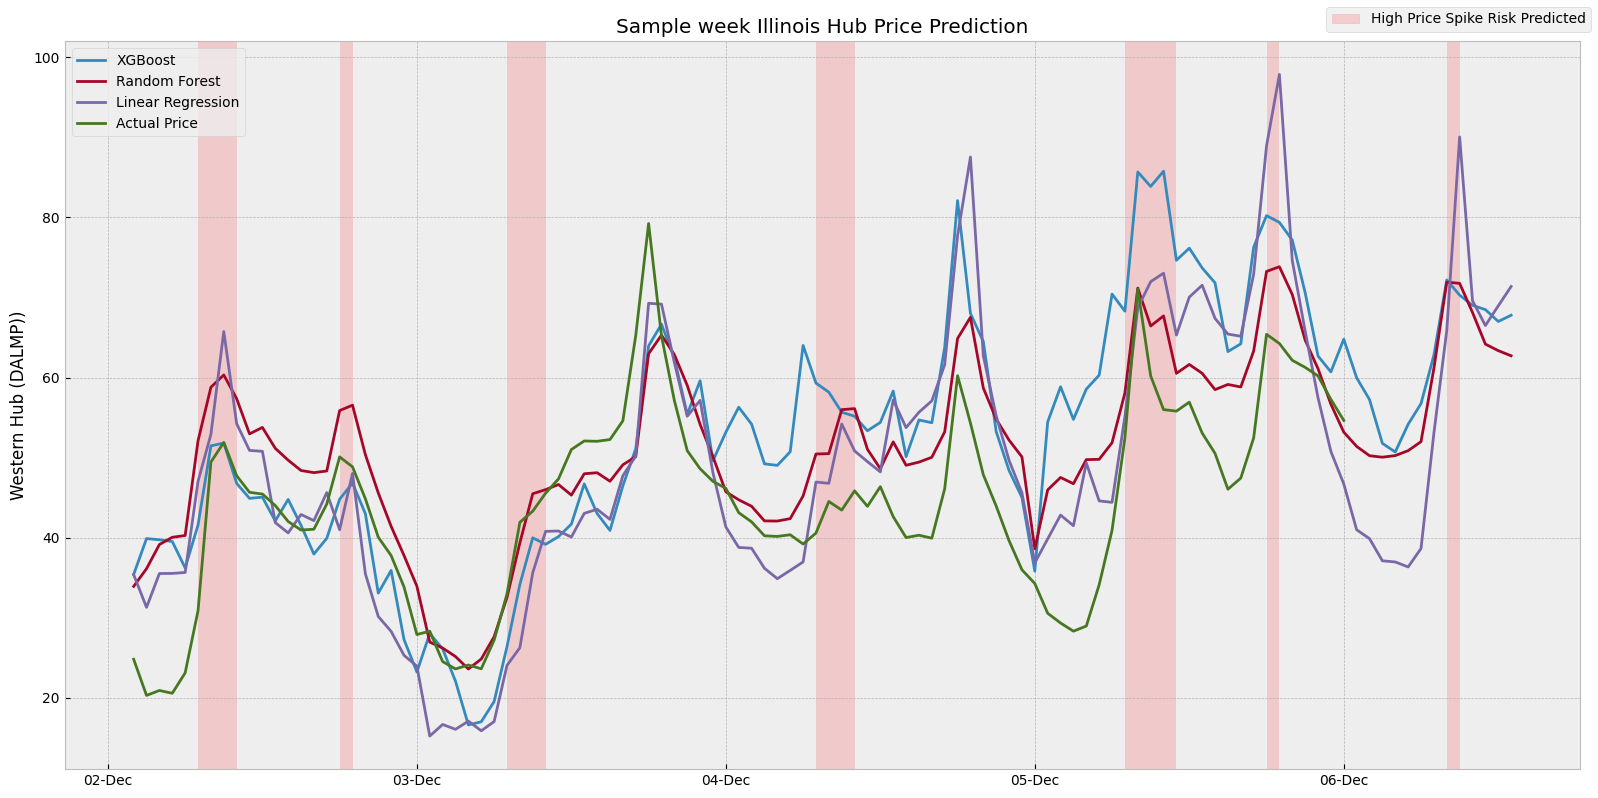

In [34]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)
dff['DATETIME']=pd.to_datetime(dff['DATETIME'])
xgbl,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost')
rf,=plt.plot(dff['DATETIME'], dff['West Hub rf Prices'], label='Random Forest')
lm,=plt.plot(dff['DATETIME'], dff['West Hub lm Prices'], label='Linear Regression')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual Price')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Illinois Hub Price Prediction")
ax.set_ylabel("Western Hub (DALMP))")

dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,rf,lm,actuals],loc='upper left')
plt.show()

### Sample Week Illinois Hub Price Prediction with Spike Probabilities

In [39]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:10000000602,DALMP:10000000602,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
df=df_preprocessing(dfs[0])
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
find_spikes_dalmp(df,lag=6,thresh=2.5,influence=0.25)
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)
#split into train and test

X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['DALMP'],df,'DALMP')  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df,'DALMP')
rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df,'DALMP')
lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df, 'DALMP')

clf=RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)


probabilities=pd.DataFrame(clf.predict_proba(X_test),columns=['Sneg', 'S0', 'S1'])
d={ "West Hub XGB PRICES": y_pred, 
   'West Hub rf Prices': y_pred_rf,
   'West Hub lm Prices': y_pred_lm,
   "Actuals": inverse_transform(y_test,df, 'DALMP'),
   "Spikes":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1).reset_index(drop=True)
dff=pd.concat([dff, probabilities], axis=1)


[17:33:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
#dff.S1 is the probability of spiking
cmap='RdYlGn_r'
#Scale S1 so that it goes between 0 and 1 
dff.S1=dff.S1/max(dff.S1)
grad=dff.S1
grad=np.vstack((grad,grad))

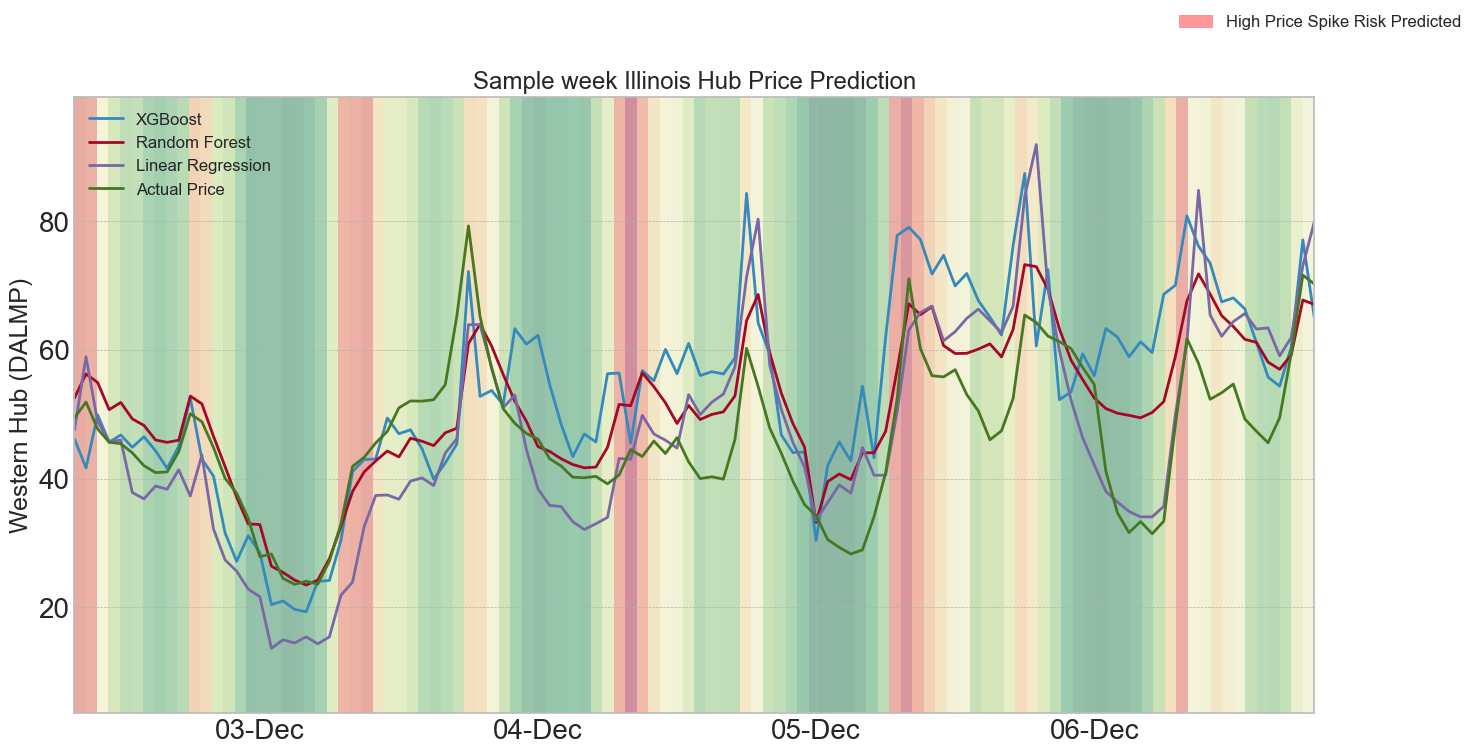

In [46]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8))
ax.set(xlim=[min(dff.DATETIME), max(dff.DATETIME)],ylim=[min(dff.Actuals)-20, max(dff.Actuals)+20], autoscale_on=False)
dff['DATETIME']=pd.to_datetime(dff['DATETIME'])
xgbl,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost')
rf,=plt.plot(dff['DATETIME'], dff['West Hub rf Prices'], label='Random Forest')
lm,=plt.plot(dff['DATETIME'], dff['West Hub lm Prices'], label='Linear Regression')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual Price')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Illinois Hub Price Prediction")
ax.set_ylabel("Western Hub (DALMP)", fontsize='18')

#dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes 1']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.4, label='High Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,rf,lm,actuals],loc='upper left')

ax.imshow(grad, aspect='auto', cmap=cmap,alpha=0.4,extent=(0, 1, 0, 1), transform=ax.transAxes)
plt.show()

### Adding Prediction Intervals to Regressors

In [70]:
#Idea: https://blog.datadive.net/prediction-intervals-for-random-forests/

In [77]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:10000000602,DALMP:10000000602,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
df=df_preprocessing(dfs[0])
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
find_spikes_dalmp(df,lag=6,thresh=2.5,influence=0.25)
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)
#split into train and test

X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = df['DALMP']  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)

rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',min_samples_leaf=1,n_jobs=-1)
rf.fit(X_train, y_train)  

clf=RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)



In [78]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.iloc[x].values.reshape(1,-1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [79]:
err_down, err_up = pred_ints(rf, X_test, percentile=70)
y_pred_rf=rf.predict(X_test)
d={  
    'West Hub rf Prices': y_pred_rf,
    "Lower rf": y_pred_rf-err_down,
    "Upper rf": y_pred_rf+err_up,
    "Actuals": y_test,
    "Spikes":spike_pred,
    }
probabilities=pd.DataFrame(clf.predict_proba(X_test),columns=['Sneg', 'S0', 'S1'])
dff2=pd.concat([X_test, pd.DataFrame(d), df['DATETIME'][-len(pd.DataFrame(d)):]], axis=1).reset_index(drop=True)
dff2=pd.concat([dff2, probabilities], axis=1)

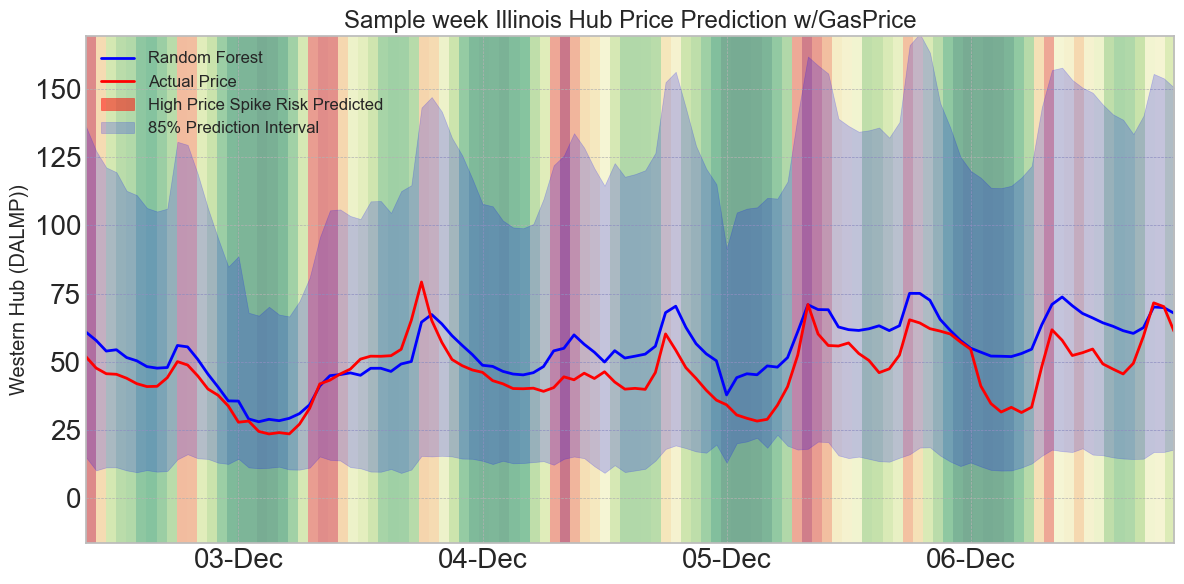

In [80]:
cmap='RdYlGn_r'
#Scale S1 so that it goes between 0 and 1 
dff2.S1=dff2.S1/max(dff2.S1)
grad=dff2.S1
grad=np.vstack((grad,grad))
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12, 6),tight_layout=True)
ax.set(xlim=[min(dff2.DATETIME), max(dff2.DATETIME)],ylim=[min(dff2.Actuals)-40, max(dff2.Actuals)+90], autoscale_on=False)
dff2['DATETIME']=pd.to_datetime(dff2['DATETIME'])

rf,=plt.plot(dff2['DATETIME'], dff2['West Hub rf Prices'], label='Random Forest', color='blue')
plt.fill_between(dff2['DATETIME'], dff2['Lower rf'], dff2['Upper rf'], alpha=0.2, color='blue')
actuals,=plt.plot(dff2['DATETIME'], dff2['Actuals'], label='Actual Price', color='red')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Illinois Hub Price Prediction w/GasPrice")
ax.set_ylabel("Western Hub (DALMP))")


red_patch = mpatches.Patch(color='red',alpha=0.5, label='High Price Spike Risk Predicted')
blue_patch=mpatches.Patch(color='blue', alpha=0.2, label='85% Prediction Interval')
#fig.legend(handles=[red_patch, blue_patch])
ax.legend(handles=[rf,actuals, red_patch, blue_patch],loc='upper left')

ax.imshow(grad, aspect='auto', cmap=cmap,alpha=0.5,extent=(0, 1, 0, 1), transform=ax.transAxes)
plt.show()


### PnL Backtests

The succes metric used to evaluate model performance is PnL. \
The following three methods were used for PnL calculation:
1. Do Nothing Approach: GENERATION_MW * RTLMP for each hour
2. Tenaska Strategy: GENERATION_MW*RTLMP - DA_MW*(DALMP-RTLMP) (for each hour)
3. Spike Strategy: During Spike Hours (red zones) adopt the Do Nothing Approach. During non spike hours: GENERATION_MW *RTLMP + UL_FORECAST_VOLUME*(DALMP-RTLMP)\
To account for errors in UL Forecast, approach 3 with 65% error on the forecast volumes was also computed. 


In [81]:
#Predownload data for YTD 

user_auth=(username, password)
dates = pd.period_range(start='2021-11-01', end=date.today(),freq='M').strftime('%Y-%m-01')
data=pd.DataFrame()
for i in range (len(dates)-1): # Repeatedly call the DSAPI endpoint in html format
        start_dt = dates[i]
        end_dt = dates[i+1]
        print("Loading data... "+start_dt+"->"+end_dt)
        PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate={}&enddate={}&items=RTLMP:10000000602,DALMP:10000000602,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'.format(start_dt, end_dt)

        dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
        dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
        data=pd.concat([data,dfs[0]]) #append html dataframe to the end of df

Loading data... 2021-11-01->2021-12-01
Loading data... 2021-12-01->2022-01-01
Loading data... 2022-01-01->2022-02-01
Loading data... 2022-02-01->2022-03-01
Loading data... 2022-03-01->2022-04-01
Loading data... 2022-04-01->2022-05-01
Loading data... 2022-05-01->2022-06-01
Loading data... 2022-06-01->2022-07-01
Loading data... 2022-07-01->2022-08-01
Loading data... 2022-08-01->2022-09-01
Loading data... 2022-09-01->2022-10-01
Loading data... 2022-10-01->2022-11-01
Loading data... 2022-11-01->2022-12-01


In [82]:
#Volume data comes from a predownloaded Snowflake query, saved locally
prod=pd.read_csv('UL forecast daily and DART.csv', parse_dates=True)
prod['DATETIME']=pd.to_datetime(prod.MARKET_DATE)+pd.to_timedelta(prod.MARKET_HOUR, unit='h')
prod=prod[['DATETIME', 'DA_MW','DA_LMP', 'GENERATION_MW', 'RT_LMP', 'PREVIOUS_DAY_FORECAST_VOLUME']]

In [83]:
#Merge the Volumes with our YESEnergy Data
data['DATETIME']=pd.to_datetime(data['DATETIME'])
data=data.merge(prod, on='DATETIME')
data['DATETIME']=pd.to_datetime(data['DATETIME'])

In [84]:
df=df_preprocessing(data, backtest=True)
df=prepare_forecast(df)

In [85]:
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
#DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop([
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)

### Define some Backtesting helper functions for Sugar Creek


In [86]:

def pnl_test_get_res(df,Lag, Threshold, Influence,start_date="2022-04-01", end_date="2022-06-01", fast=False):

    df['DATETIME']=pd.to_datetime(df['DATETIME'])
    mask = (df['DATETIME'] > pd.to_datetime(start_date)) & (df['DATETIME'] <= pd.to_datetime(end_date))
    df = df.loc[mask]
    df.reset_index(drop=True, inplace=True)

    #Find Spikes in Training Set
    if fast==True:
        find_spikes_fast(df,lag=Lag,thresh=Threshold)
    else:
        find_spikes(df, Lag=Lag, thresh=Threshold, influence=Influence)
    #train model
    X=df.drop(['DATETIME','PEAK','DALMP','RT_LMP','DA_LMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
    y2=df['PEAK']

    X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
      )

    clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    clf.fit(X_train, y2_train)
    spike_pred=clf.predict(X_test)
    i=len(spike_pred)
    d={ "DATETIME": df['DATETIME'][-i:], 
   'DALMP': df['DALMP'][-i:],
   'RTLMP': df['RTLMP'][-i:],
   'Spike Real':df['PEAK'][-i:],
   "Spike Predicted":spike_pred,
   "PnL: Sell RT": df['GENERATION_MW'][-i:]*(df['RTLMP'][-i:]),
   "PnL: Tenaska": df['GENERATION_MW'][-i:]*(df['RTLMP'][-i:])-df['DA_MW'][-i:]*(df['DALMP'][-i:]-df['RTLMP'][-i:]),
   "Red Zone Helper": df['PREVIOUS_DAY_FORECAST_VOLUME'][-i:]*(df['DALMP'][-i:]-df['RTLMP'][-i:])
    }
    res=pd.DataFrame(d)
    res=res.reset_index(drop=True)
    #(error on forecast, 65%) * DA UL forecast * (DALMP - RTLMP) [if not in red zone]
    res['PnL: Spike Algorithm'] = np.where((res['Spike Predicted']) == 1,res['PnL: Sell RT'], res['PnL: Sell RT']+res['Red Zone Helper'])
    res['PnL: Spike Algorithm (65%)'] = np.where((res['Spike Predicted']) == 1,res['PnL: Sell RT'], res['PnL: Sell RT']+(0.65*res['Red Zone Helper']))
    res=res.drop(['Red Zone Helper'],axis=1)
    
    return res

In [87]:
def pnl_test_get_res_dalmp(df,Lag, Threshold, Influence,start_date="2022-04-01", end_date="2022-06-01"):
    '''Uses the DALMP spike finder function to better define spikes. Records spike probabilities.'''
    df['DATETIME']=pd.to_datetime(df['DATETIME'])
    mask = (df['DATETIME'] > pd.to_datetime(start_date)) & (df['DATETIME'] <= pd.to_datetime(end_date))
    df = df.loc[mask]
    df.reset_index(drop=True, inplace=True)
    #Find Spikes in Training Set
    find_spikes_dalmp(df,lag=Lag,thresh=Threshold, influence=Influence)
    #train model
    X=df.drop(['DATETIME','PEAK','DALMP','RT_LMP','DA_LMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
    y2=df['PEAK']

    X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
      )

    clf=RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, n_jobs=-1)
    clf.fit(X_train, y2_train)
    spike_pred=clf.predict(X_test)
    probabilities=pd.DataFrame(clf.predict_proba(X_test),columns=['Sneg', 'S0', 'S1'])
    i=len(spike_pred)
    d={ "DATETIME": df['DATETIME'][-i:], 
       'DALMP': df['DALMP'][-i:],
       'RTLMP': df['RTLMP'][-i:],
       'Spike Real':df['PEAK'][-i:],
       "Spike Predicted":spike_pred,
       "PnL: Sell RT": df['GENERATION_MW'][-i:]*(df['RTLMP'][-i:]),
       "PnL: Tenaska": df['GENERATION_MW'][-i:]*(df['RTLMP'][-i:])-df['DA_MW'][-i:]*(df['DALMP'][-i:]-df['RTLMP'][-i:]),
       "Red Zone Helper": df['PREVIOUS_DAY_FORECAST_VOLUME'][-i:]*(df['DALMP'][-i:]-df['RTLMP'][-i:])
    }
    res=pd.DataFrame(d)
    res=res.reset_index(drop=True)
    #(error on forecast, 65%?) * DA UL forecast * (DALMP - RTLMP) [if not in red zone]
    res['PnL: Spike Algorithm'] = np.where((res['Spike Predicted']) == 1,res['PnL: Sell RT'], res['PnL: Sell RT']+res['Red Zone Helper'])
    res['PnL: Spike Algorithm (65%)'] = np.where((res['Spike Predicted']) == 1,res['PnL: Sell RT'], res['PnL: Sell RT']+(0.65*res['Red Zone Helper']))
    res=res.drop(['Red Zone Helper'],axis=1)
    
    res=pd.concat([res,probabilities],axis=1)
    res=res.reset_index(drop=True)
    #Scale resulting probabilities
    res.S1=res.S1/max(res.S1)
    res.S0=res.S0/max(res.S0)
    res.Sneg=res.Sneg/max(res.Sneg)
    return res

In [22]:
pnl_test_get_res_dalmp(df, 400,0.5,1)

,DATETIME,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,S1
0,2022-05-28 23:00:00,62.91,35.53,-1,-1,5933.58106,9328.70106,10460.20694,8875.887882,0.935118,0.127731,0.017467
1,2022-05-29 00:00:00,55.78,19.52,-1,-1,3298.88000,7802.37200,9303.89860,7202.142090,0.916581,0.168067,0.010917
2,2022-05-29 01:00:00,50.18,20.19,-1,-1,3391.94019,7041.72319,8248.88067,6548.951502,0.949537,0.124370,0.004367
3,2022-05-29 02:00:00,41.77,5.80,-1,-1,962.80000,5426.67700,6918.96439,4834.306854,0.969104,0.094118,0.003275
4,2022-05-29 03:00:00,38.27,4.72,-1,-1,797.68472,4961.23972,6350.04197,4406.716933,0.987642,0.065546,0.002183
...,...,...,...,...,...,...,...,...,...,...,...,...
69,2022-05-31 20:00:00,115.89,134.92,1,1,8095.46984,6824.26584,8095.46984,8095.469840,0.012358,0.139496,0.987991
70,2022-05-31 21:00:00,114.26,120.17,1,1,5167.31000,4740.60800,5167.31000,5167.310000,0.016478,0.189916,0.950873
71,2022-05-31 22:00:00,109.24,118.12,1,1,8268.40000,7604.17600,8268.40000,8268.400000,0.024717,0.273950,0.887555
72,2022-05-31 23:00:00,98.85,98.68,1,1,6512.88000,6524.45700,6512.88000,6512.880000,0.023687,0.334454,0.849345


In [88]:
def run_through_dates(df,Lag, Threshold, Influence, base):
    date_list = [str((pd.to_datetime(base) + timedelta(days=3*x)).date()) for x in range(111)] #10*3=30 days or one month worth of backtesting
    #initialize df
    d=pd.DataFrame()
    for start_dt in date_list:
        end_dt=str((pd.to_datetime(start_dt)+timedelta(days=2*30)).date())
        #call pnl test get res with start_dt and end_dt
        df_new=pnl_test_get_res(df,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, fast=True)
        #concat dfs as you loop through
        d=pd.concat([d, df_new],axis=0)
    d.reset_index(drop=True, inplace=True)
    return d

In [89]:
def run_through_dates_dalmp(df,Lag, Threshold, Influence, base):
    date_list = [str((pd.to_datetime(base) + timedelta(days=3*x)).date()) for x in range(111)] #10*3=30 days or one month worth of backtesting
    #initialize df
    d=pd.DataFrame()
    for start_dt in date_list:
        end_dt=str((pd.to_datetime(start_dt)+timedelta(days=2*30)).date())
        #call pnl test get res with start_dt and end_dt
        df_new=pnl_test_get_res_dalmp(df,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt)
        #concat dfs as you loop through
        d=pd.concat([d, df_new],axis=0)
    d.reset_index(drop=True, inplace=True)
    return d

In [ ]:
def my_scoring_func_sugar_creek(df,Lag, Threshold, Influence, base='2022-01-01'):
    '''Function call run through dates and obtains resulting PnL for DA selling and spike methods'''
    res=run_through_dates(df,Lag, Threshold, Influence, base)
    return res['PnL: Spike Algorithm'].sum(), res['PnL: Tenaska'].sum(), res['PnL: Sell RT'].sum()

#run some tests

pd.options.mode.chained_assignment = None  # default='warn'

def objective_sugar_creek(trial):
    Lag = trial.suggest_int("Lag", 4, 400, step=4)
    Threshold=trial.suggest_float("Threshold", 0.25, 7.5, step=0.25)
    #Influence = trial.suggest_float("Influence", 0.0, 1.0)
    Influence=1 #we will be running the tests in fast mode, so we don't have access to the influence variable
    pnl_spike_sum, pnl_tenaska_sum, pnl_sell_rt_sum = my_scoring_func_sugar_creek(df,Lag, Threshold, Influence, base='2021-12-01')
    trial.suggest_categorical("PnL: Tenaska", choices=[pnl_tenaska_sum])
    trial.suggest_categorical("PnL: Sell RT", choices=[pnl_sell_rt_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective_sugar_creek, n_trials=20, n_jobs=-1)

[I 2022-12-05 18:43:51,309] A new study created in memory with name: no-name-a4fa9688-3185-44d1-8261-214eee153a11


In [ ]:
pnl_sugar_creek=run_through_dates_dalmp(df, 32, 0.5,0.17, '2021-12-01')

In [26]:
pnl_sugar_creek.reset_index(inplace=True, drop=True)

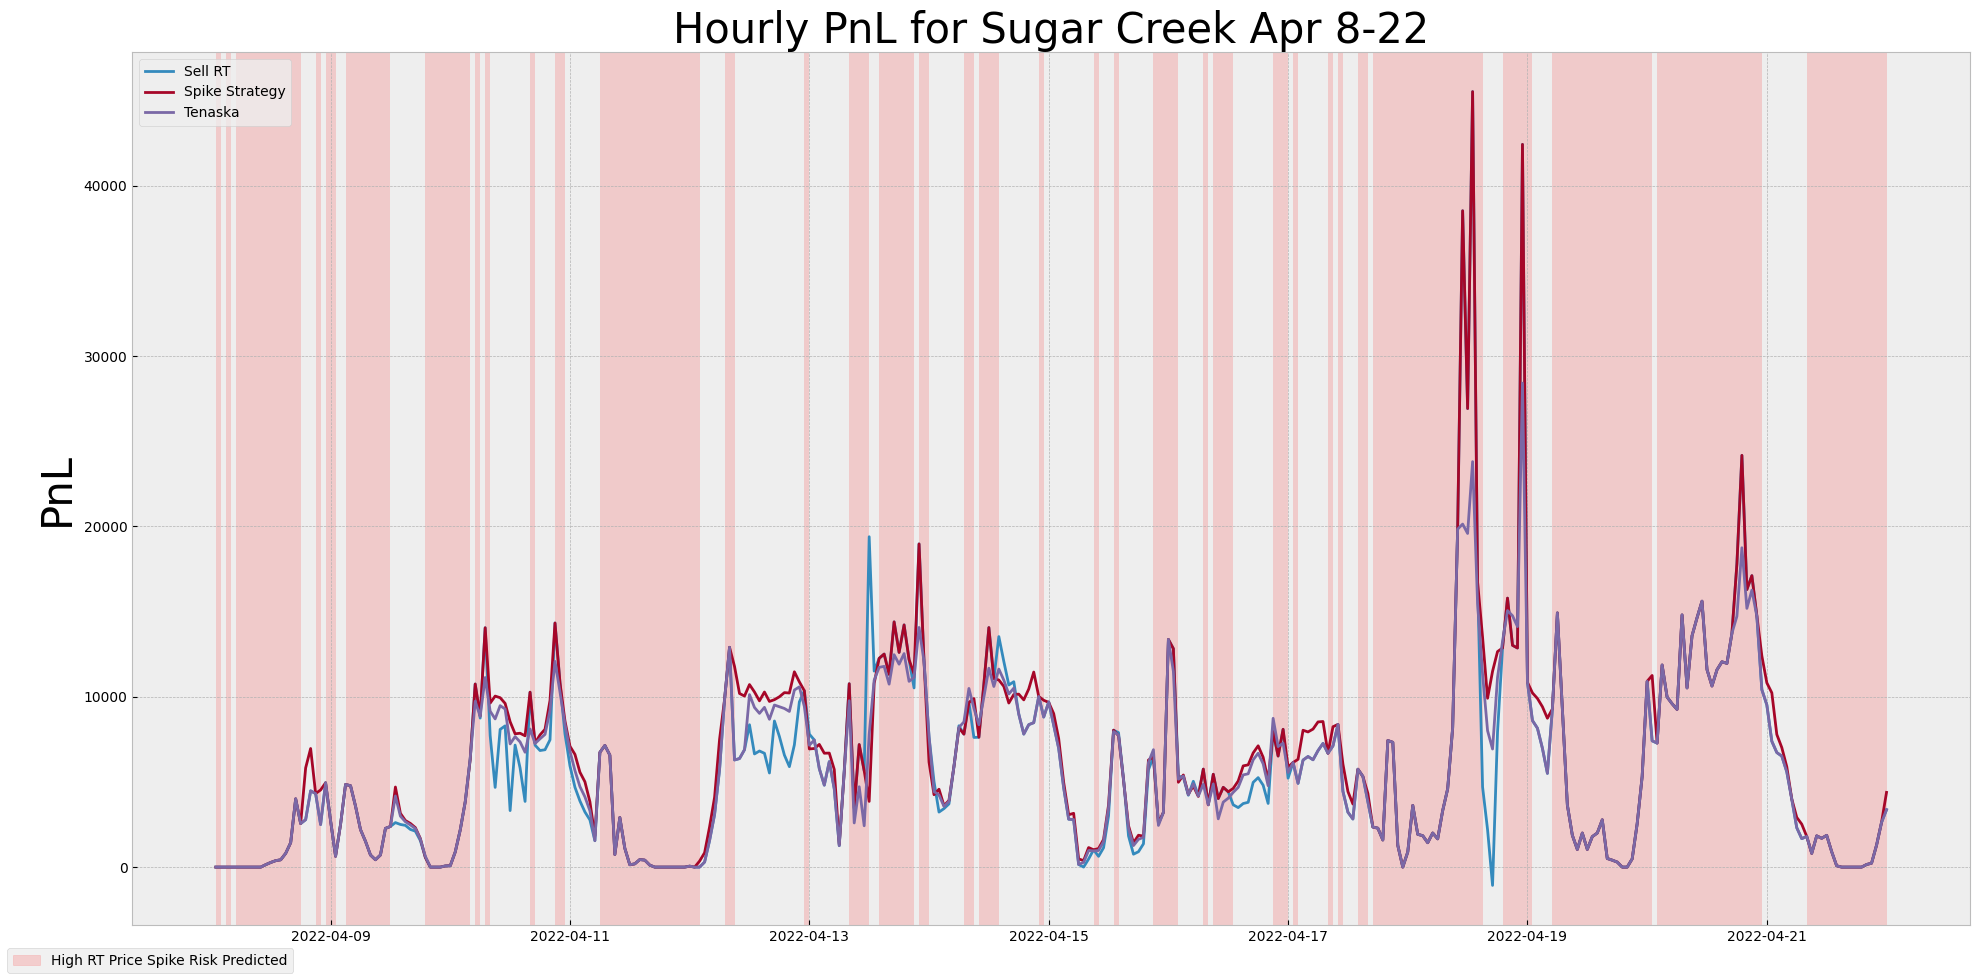

In [27]:
# Plot DALMP vs RTLMP during spike along with our spike prediction and PnL

mask = (pnl_sugar_creek['DATETIME'] > pd.to_datetime('2022-04-08')) & (pnl_sugar_creek['DATETIME'] <= pd.to_datetime('2022-04-22'))
df_hourly_A = pnl_sugar_creek.loc[mask]


plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (20, 10),tight_layout=True)

pnl1,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Sell RT'], label='Sell RT')

pnl2,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Spike Algorithm'], label='Spike Strategy')

pnl3,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Tenaska'], label='Tenaska')

#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Hourly PnL for Sugar Creek Apr 8-22", fontsize='30')
ax.set_ylabel("PnL",fontsize='30')

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2, pnl3],loc='upper left')
plt.rcParams.update({'font.size': '22'})
plt.show()

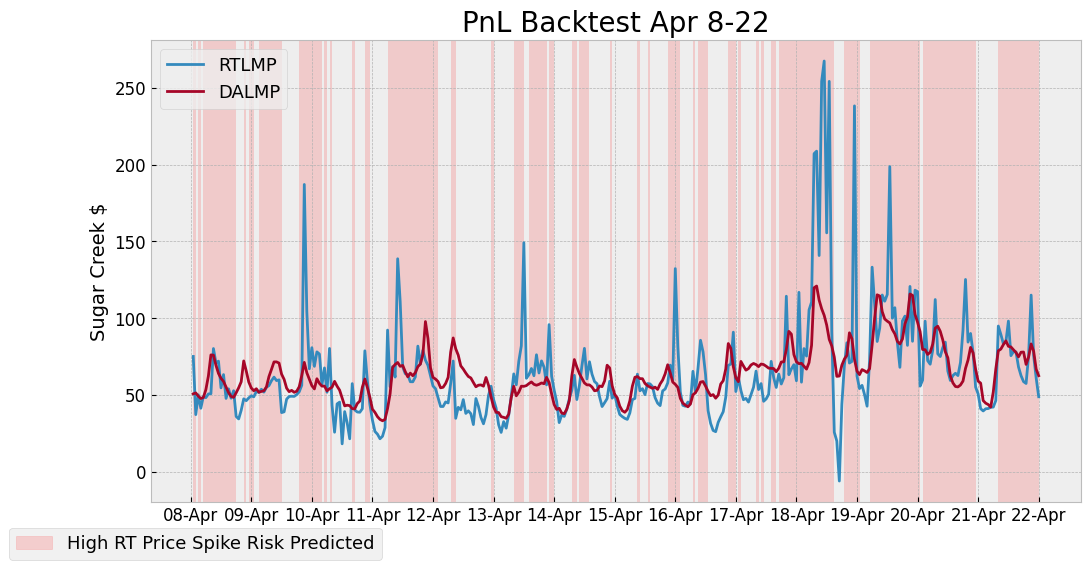

In [33]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12,6))
res=df_hourly_A
res['DATETIME']=pd.to_datetime(res['DATETIME'])
rtlmp,=plt.plot(res['DATETIME'], res['RTLMP'], label='RTLMP')
dalmp,=plt.plot(res['DATETIME'], res['DALMP'], label='DALMP')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("PnL Backtest Apr 8-22", fontsize='20')
ax.set_ylabel("Sugar Creek $", fontsize='14')

res.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left', fontsize='13')
ax.legend(handles=[rtlmp,dalmp],loc='upper left', fontsize='13')
plt.rcParams.update({'font.size': '12'})
plt.show()

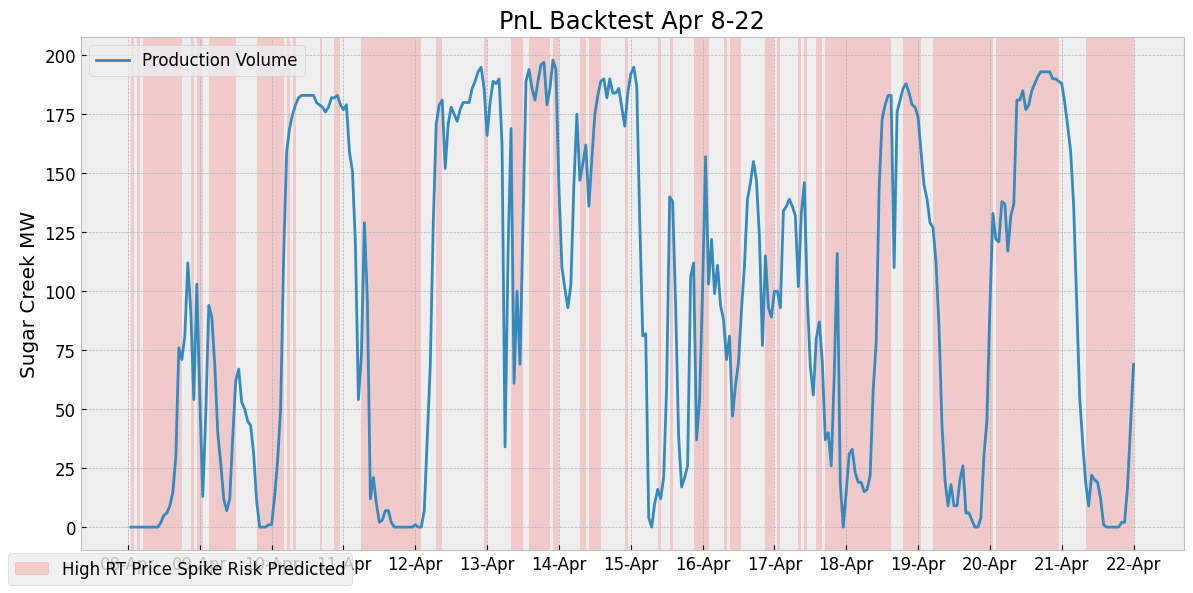

In [34]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12, 6),tight_layout=True)
mask= (data['DATETIME'] > pd.to_datetime('2022-04-08')) & (data['DATETIME'] <= pd.to_datetime('2022-04-22'))
res=data.loc[mask]
res['DATETIME']=pd.to_datetime(res['DATETIME'])
prod,=plt.plot(res['DATETIME'], res['GENERATION_MW'], label='Production Volume')



ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("PnL Backtest Apr 8-22")
ax.set_ylabel("Sugar Creek MW")

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[prod],loc='upper left')
plt.show()

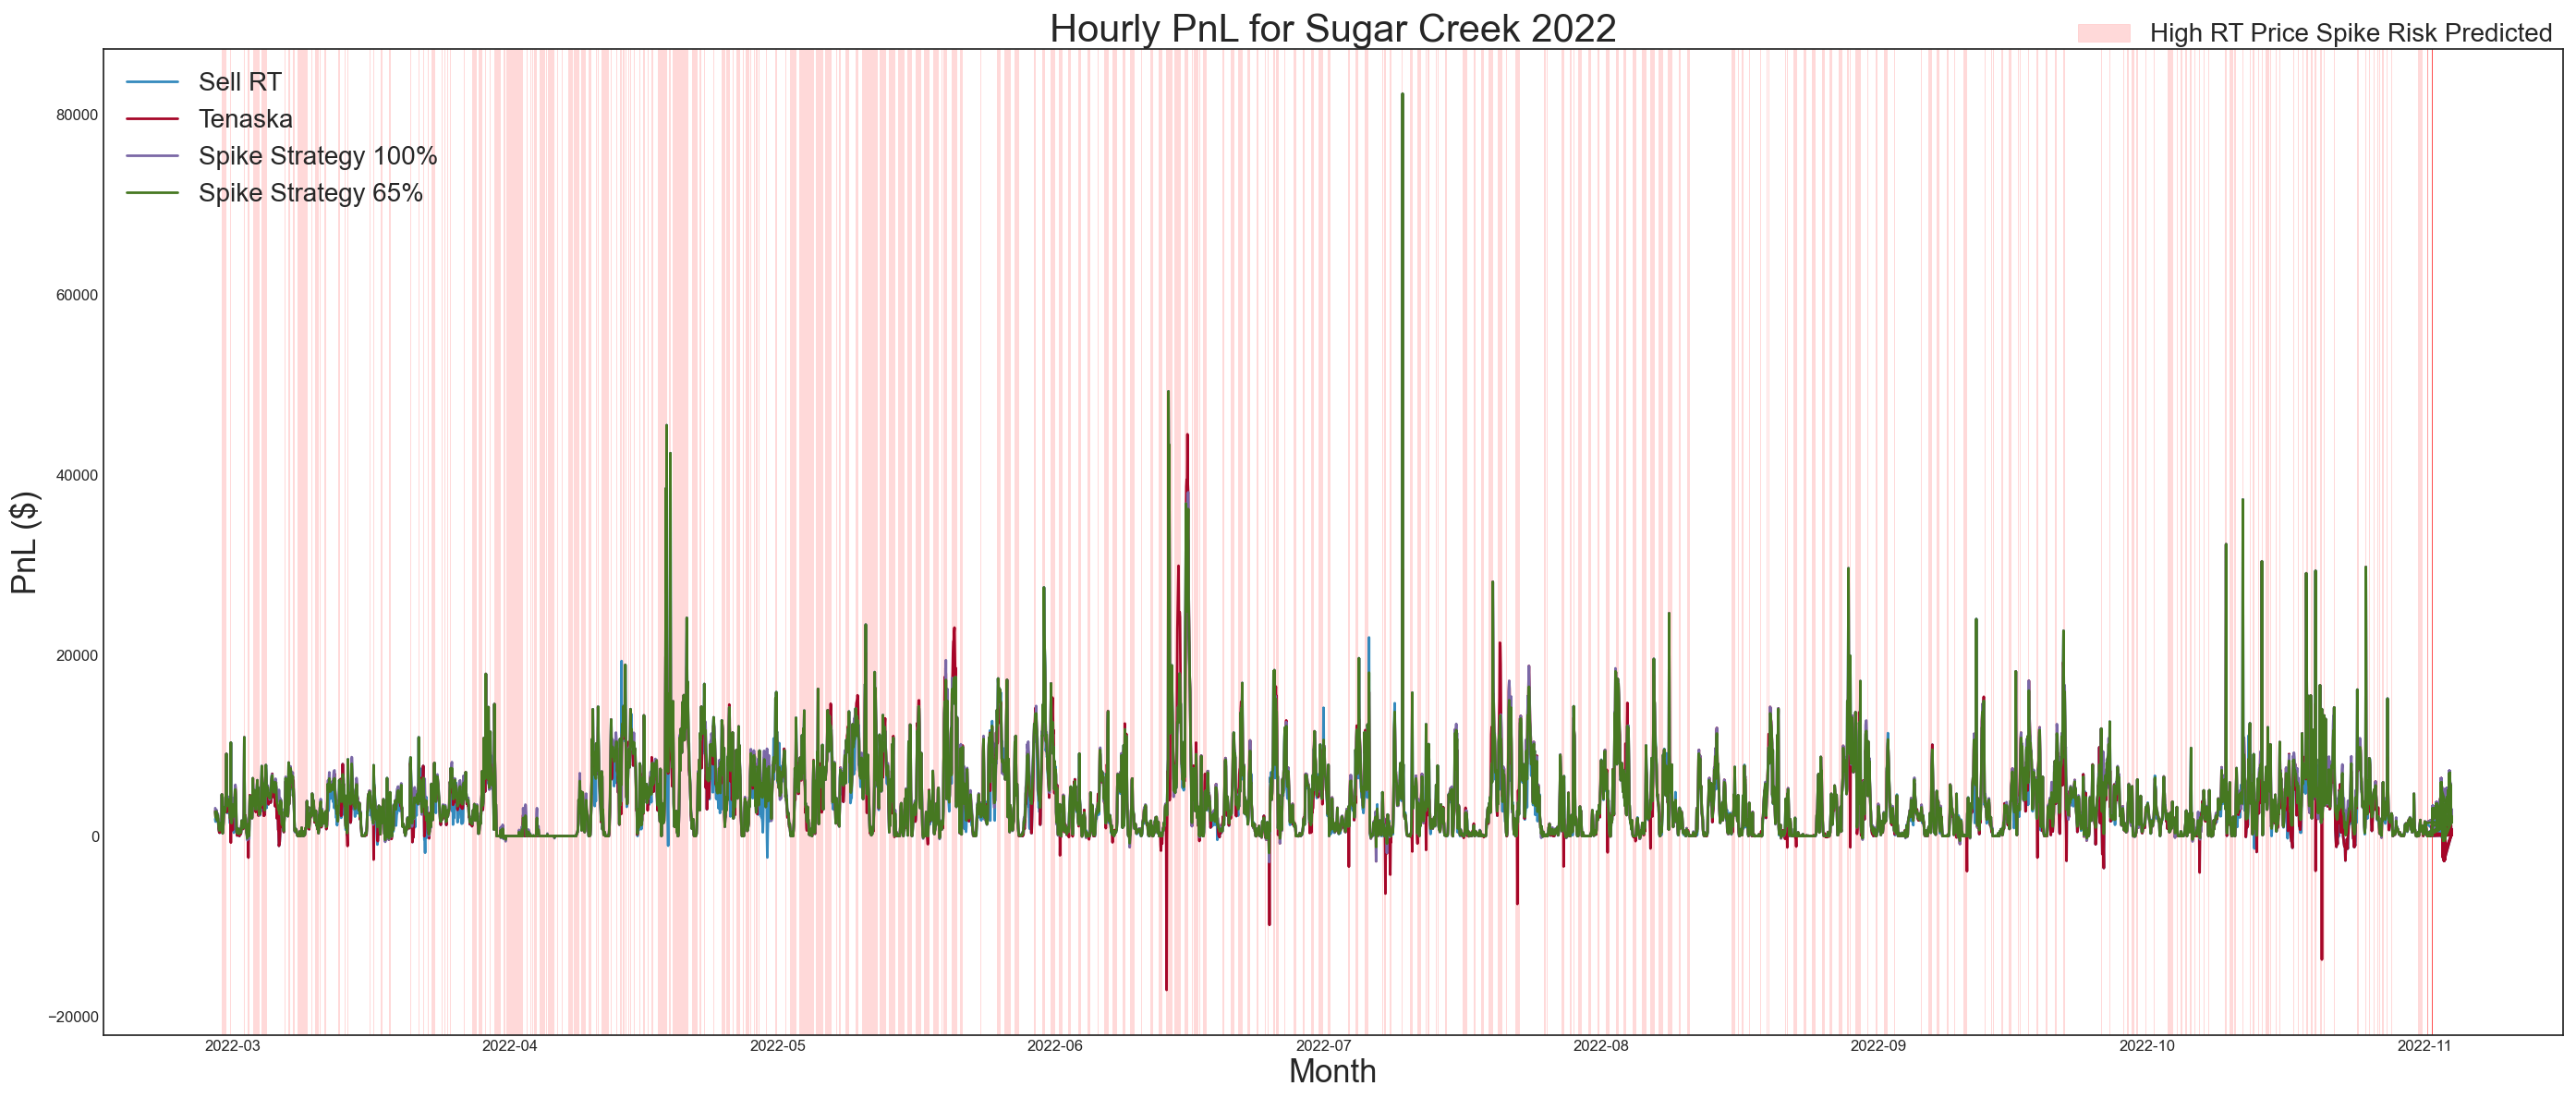

In [35]:
#Chart 1 hourly PnL over the course of the whole year
#mask = (pnl_sugar_creek['DATETIME'] > pd.to_datetime('2022-04-08')) & (pnl_sugar_creek['DATETIME'] <= pd.to_datetime('2022-04-22'))
df_hourly_A = pnl_sugar_creek


plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(28,12),
                       tight_layout=True)

pnl1,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Sell RT'], label='Sell RT')
pnl3,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Tenaska'], label='Tenaska')
pnl2,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Spike Algorithm'], label='Spike Strategy 100%')
pnl4,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Spike Algorithm (65%)'], label='Spike Strategy 65%')



ax.xaxis.set_major_locator(md.MonthLocator())
#ax.xaxis.set_major_formatter(md.MonthFormatter('%b'))
ax.set_title("Hourly PnL for Sugar Creek 2022", fontsize='30')
ax.set_ylabel("PnL ($)", fontsize='25')
ax.set_xlabel("Month", fontsize='25')

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='upper right', fontsize='20')
ax.legend(handles=[pnl1,pnl3,pnl2,  pnl4],loc='upper left', fontsize='20')
plt.rc('xtick', labelsize='24') 
plt.rc('ytick', labelsize='24') 
plt.show()

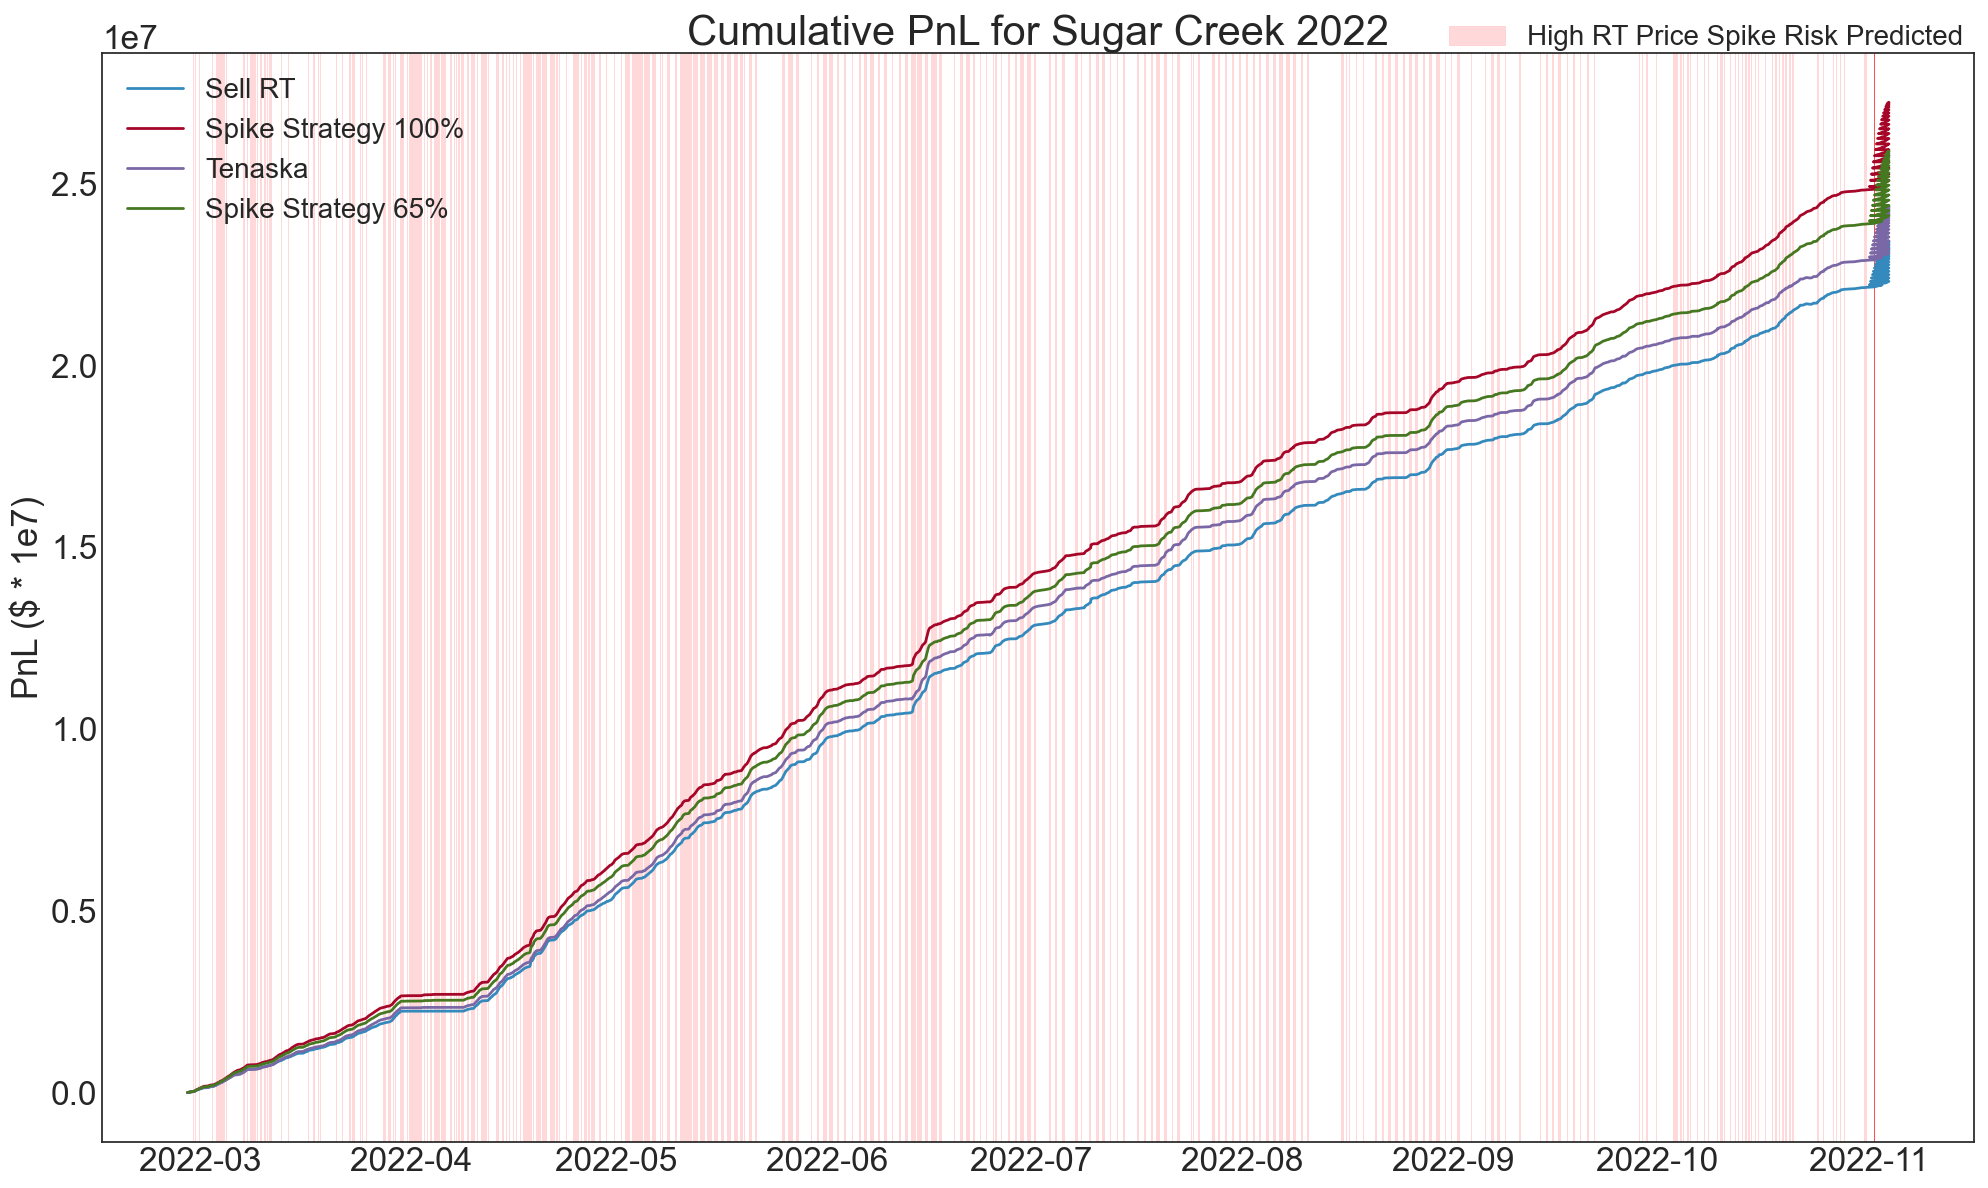

In [36]:
#Chart 2 cumulative PnL over the course of the whole year

df_hourly_A = pnl_sugar_creek


plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(20,12),
                       tight_layout=True)

pnl1,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Sell RT']), label='Sell RT')

pnl2,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Spike Algorithm']), label='Spike Strategy 100%')

pnl3,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Tenaska']), label='Tenaska')

pnl4,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Spike Algorithm (65%)']), label='Spike Strategy 65%')

ax.xaxis.set_major_locator(md.MonthLocator())
#ax.xaxis.set_major_formatter(md.MonthFormatter('%b'))
ax.set_title("Cumulative PnL for Sugar Creek 2022", fontsize='30')
ax.set_ylabel("PnL ($ * 1e7)", fontsize='25')

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='upper right', fontsize='20')
ax.legend(handles=[pnl1,pnl2, pnl3, pnl4],loc='upper left', fontsize='20')
plt.rc('xtick', labelsize='20') 
plt.rc('ytick', labelsize='20') 
plt.show()

In [37]:
#The following table shows some comparative stats for PnL
#Percent Win is the amount of hours for which real time and predicted spikes matched up perfectly
#cumsum columns are the cumulative PnL up to the particular month
#the DELTA columns are the difference in cumulative PnL between the spike algorithm and Tenaska
pnl_sugar_creek['COUNT']=1

pnl_sugar_creek['WIN']=np.where((pnl_sugar_creek['Spike Real']==pnl_sugar_creek['Spike Predicted']), 1, 0)
pnl_sugar_creek['DATE']= pd.to_datetime(pnl_sugar_creek['DATETIME']).dt.date

pnl_sugar_creek['MONTH'] = pd.to_datetime(pnl_sugar_creek['DATE']).dt.to_period('M')
df_month=pnl_sugar_creek.groupby('MONTH').sum()

df_month['PERCENT WIN']=df_month['WIN']/df_month['COUNT']*100
df_month['cumsum Tenaska']=np.cumsum(df_month['PnL: Tenaska'])
df_month['cumsum Algo']=np.cumsum(df_month['PnL: Spike Algorithm (65%)'])
df_month['cumsum Algo 100']=np.cumsum(df_month['PnL: Spike Algorithm'])
df_month['DELTA 100%']=df_month['cumsum Algo 100']-df_month['cumsum Tenaska']
df_month['DELTA 65%']=df_month['cumsum Algo']-df_month['cumsum Tenaska']
df_month

C:\Users\katvo\AppData\Local\Temp\ipykernel_12228\681275945.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month=pnl_sugar_creek.groupby('MONTH').sum()


,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,S1,COUNT,WIN,PERCENT WIN,cumsum Tenaska,cumsum Algo,cumsum Algo 100,DELTA 100%,DELTA 65%
MONTH,,,,,,,,,,,,,,,,,,,
2022-02,1888.45,2069.28,-20,-26,1.060704e+05,1.039506e+05,1.268657e+05,1.195873e+05,32.338895,19.698361,11.438217,46,42,91.304348,1.039506e+05,1.195873e+05,1.268657e+05,2.291512e+04,1.563676e+04
2022-03,29809.84,28096.55,-182,-308,2.135417e+06,2.230294e+06,2.540302e+06,2.398592e+06,447.627037,345.454225,250.396987,744,573,77.016129,2.334245e+06,2.518180e+06,2.667168e+06,3.329228e+05,1.839348e+05
2022-04,43879.75,42204.46,-176,43,3.218062e+06,3.333467e+06,3.740868e+06,3.557886e+06,348.302181,368.137188,363.707140,720,542,75.277778,5.667712e+06,6.076066e+06,6.408036e+06,7.403241e+05,4.083541e+05
2022-05,55642.62,54298.99,-67,42,4.285262e+06,4.465357e+06,4.621974e+06,4.504125e+06,335.397122,378.338023,384.939817,744,532,71.505376,1.013307e+07,1.058019e+07,1.103001e+07,8.969404e+05,4.471213e+05
2022-06,61462.78,59350.18,-149,-80,3.036773e+06,3.138791e+06,3.175885e+06,3.127196e+06,328.228592,302.441908,268.735432,720,545,75.694444,1.327186e+07,1.370739e+07,1.420589e+07,9.340347e+05,4.355262e+05
2022-07,63224.74,62052.05,-255,-212,2.330743e+06,2.487364e+06,2.621506e+06,2.519739e+06,388.025852,319.210062,232.332991,744,574,77.150538,1.575922e+07,1.622713e+07,1.682740e+07,1.068176e+06,4.679007e+05
2022-08,69232.35,70136.75,-194,-197,2.580670e+06,2.583472e+06,2.694741e+06,2.654816e+06,387.873701,258.201766,231.067469,744,596,80.107527,1.834270e+07,1.888194e+07,1.952214e+07,1.179445e+06,5.392447e+05
2022-09,53804.34,51086.92,-207,-368,2.167032e+06,2.242492e+06,2.505032e+06,2.386732e+06,430.992431,291.828228,182.085932,720,532,73.888889,2.058519e+07,2.126867e+07,2.202717e+07,1.441985e+06,6.834844e+05
2022-10,35807.44,34907.73,-249,-338,2.288493e+06,2.307224e+06,2.805608e+06,2.624618e+06,426.406610,353.041030,236.980626,744,565,75.940860,2.289241e+07,2.389329e+07,2.483278e+07,1.940369e+06,1.000879e+06


### Adding Gas Price as a Predictor Variable

In the past, when building the model for the Western Hub, we opted out of including gas prices as a predictor since it is highly correlated to other variables and getting forecast gas prices is not easy. 
Here we investigate whether adding gas price as a predictor could improve our PnL. 


In [49]:
#Lets compare the predictions we would get for a sample week using vs not using gas price as an x variable
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:10000000602,DALMP:10000000602,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
df=df_preprocessing(dfs[0])
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
find_spikes_dalmp(df,lag=6,thresh=2.5,influence=0.25)
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)
#split into train and test

X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['DALMP'],df,'DALMP')  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df,'DALMP')
rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df,'DALMP')
lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df, 'DALMP')

clf=RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)
probabilities=pd.DataFrame(clf.predict_proba(X_test),columns=['Sneg', 'S0', 'S1'])
#dff.S1 is the probability of spiking
d={ "West Hub XGB PRICES": y_pred, 
   'West Hub rf Prices': y_pred_rf,
   'West Hub lm Prices': y_pred_lm,
   "Actuals": inverse_transform(y_test,df, 'DALMP'),
   "Spikes 1":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1).reset_index(drop=True)
dff=pd.concat([dff, probabilities], axis=1)

[17:44:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
#Compare to the graph you would get WITh gasprice as predictor
#GASPRICE:10000002629 Chicago CityGates

#Lets compare the predictions we would get for a sample week using vs not using gas price as an x variable
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:10000000602,DALMP:10000000602,GASPRICE:10000002629,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
df=df_preprocessing(dfs[0])
#we need to offset the gas price column by 8 hours
df['Chicago Citygates (GASPRICE)']=df['Chicago Citygates (GASPRICE)'].shift(8) #will shift down by 8 since gas day start at 8
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
find_spikes_dalmp(df,lag=6,thresh=2.5,influence=0.25)
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)
#split into train and test

X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['DALMP'],df,'DALMP')  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df,'DALMP')
rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df,'DALMP')
lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df, 'DALMP')

clf=RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)
probabilities=pd.DataFrame(clf.predict_proba(X_test),columns=['Sneg', 'S0', 'S1'])
#dff.S1 is the probability of spiking
d={ "West Hub XGB PRICES": y_pred, 
   'West Hub rf Prices': y_pred_rf,
   'West Hub lm Prices': y_pred_lm,
   "Actuals": inverse_transform(y_test,df, 'DALMP'),
   "Spikes 1":spike_pred,
   }
res=pd.DataFrame(d)
dff2=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1).reset_index(drop=True)
dff2=pd.concat([dff2, probabilities], axis=1)

[17:42:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


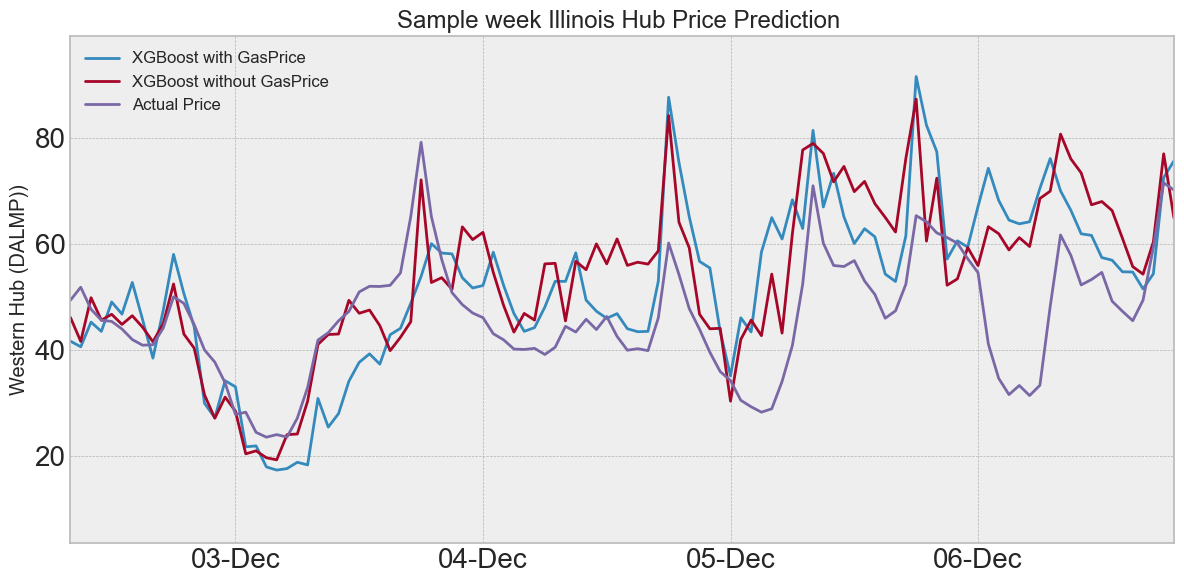

In [51]:
fig, ax = plt.subplots(figsize = (12, 6),tight_layout=True)
ax.set(xlim=[min(dff2.DATETIME), max(dff2.DATETIME)],ylim=[min(dff2.Actuals)-20, max(dff2.Actuals)+20], autoscale_on=False)
dff2['DATETIME']=pd.to_datetime(dff2['DATETIME'])
xgbl1,=plt.plot(dff2['DATETIME'], dff2['West Hub XGB PRICES'], label='XGBoost with GasPrice')
xgbl2,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost without GasPrice')
actuals,=plt.plot(dff2['DATETIME'], dff2['Actuals'], label='Actual Price')

ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Illinois Hub Price Prediction ")
ax.set_ylabel("Western Hub (DALMP))")
red_patch = mpatches.Patch(color='red',alpha=0.4, label='High Price Spike Risk Predicted')
ax.legend(handles=[xgbl1,xgbl2,actuals],loc='upper left')
plt.show()


### Running Backtests with GasPrice

In [52]:
#Now lets find the optimal params and see if gas price affects them much
user_auth=(username, password)
dates = pd.period_range(start='2021-11-01', end=date.today(),freq='M').strftime('%Y-%m-01')
data=pd.DataFrame()
for i in range (len(dates)-1): # Repeatedly call the DSAPI endpoint in html format
        start_dt = dates[i]
        end_dt = dates[i+1]
        print("Loading data... "+start_dt+"->"+end_dt)
        PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate={}&enddate={}&items=RTLMP:10000000602,DALMP:10000000602,GASPRICE:10000002629,WSI_TRADER_TEMP:10000357111,WSI_FC15_TEMP:10000357111:today+48hours,WSI_TRADER_CLDC:10000357111,WSI_FC15_CLDC:10000357111:today+48hours,WSI_TRADER_PRCP:10000357111,WSI_FC15_PRCP:10000357111:today+48hours,WSI_TRADER_RH:10000357111,WSI_FC15_RH:10000357111:today+48hours,WSI_TRADER_WIND:10000357111,WSI_FC15_WIND:10000357111:today+48hours,FC_CAP_ON_OUTAGE:10002504424:today+48hours,RTLOAD:10002504424,LOAD_FORECAST:10002504424,MISO_MTD_SOLAR_FC_ORG:10002504424,REG_DERATE_GEN_OFFLINE_CAPACITY:10002504424:today+48hours'.format(start_dt, end_dt)

        dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
        dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
        data=pd.concat([data,dfs[0]]) #append html dataframe to the end of df

Loading data... 2021-11-01->2021-12-01
Loading data... 2021-12-01->2022-01-01
Loading data... 2022-01-01->2022-02-01
Loading data... 2022-02-01->2022-03-01
Loading data... 2022-03-01->2022-04-01
Loading data... 2022-04-01->2022-05-01
Loading data... 2022-05-01->2022-06-01
Loading data... 2022-06-01->2022-07-01
Loading data... 2022-07-01->2022-08-01
Loading data... 2022-08-01->2022-09-01
Loading data... 2022-09-01->2022-10-01
Loading data... 2022-10-01->2022-11-01
Loading data... 2022-11-01->2022-12-01


In [53]:
#Volume data comes from a predownloaded Snowflake query, saved locally
prod=pd.read_csv('UL forecast daily and DART.csv', parse_dates=True)
prod['DATETIME']=pd.to_datetime(prod.MARKET_DATE)+pd.to_timedelta(prod.MARKET_HOUR, unit='h')
prod=prod[['DATETIME', 'DA_MW','DA_LMP', 'GENERATION_MW', 'RT_LMP', 'PREVIOUS_DAY_FORECAST_VOLUME']]

In [56]:
#Merge the Volumes with our YESEnergy Data
data['DATETIME']=pd.to_datetime(data['DATETIME'])
data=data.merge(prod, on='DATETIME')
data['DATETIME']=pd.to_datetime(data['DATETIME'])

In [57]:
df=df_preprocessing(data, backtest=True)
df=prepare_forecast(df)

In [58]:
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTLMP','Central (RTLOAD)','WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
df_lags=makelags(df[['Central (RTLOAD)', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
#DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop([
         'Central (LOAD_FORECAST)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)

In [ ]:
def my_scoring_func_sugar_creek(df,Lag, Threshold, Influence, base='2022-01-01'):
    '''Function call run through dates and obtains resulting PnL for DA selling and spike methods'''
    res=run_through_dates_dalmp(df,Lag, Threshold, Influence, base)
    return res['PnL: Spike Algorithm'].sum(), res['PnL: Tenaska'].sum(), res['PnL: Sell RT'].sum()

#run some tests

pd.options.mode.chained_assignment = None  # default='warn'

def objective_sugar_creek(trial):
    Lag = trial.suggest_int("Lag", 4, 400, step=4)
    Threshold=trial.suggest_float("Threshold", 0.25, 7.5, step=0.25)
    Influence = trial.suggest_float("Influence", 0.0, 1.0)
    pnl_spike_sum, pnl_tenaska_sum, pnl_sell_rt_sum = my_scoring_func_sugar_creek(df,Lag, Threshold, Influence, base='2021-12-01')
    trial.suggest_categorical("PnL: Tenaska", choices=[pnl_tenaska_sum])
    trial.suggest_categorical("PnL: Sell RT", choices=[pnl_sell_rt_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective_sugar_creek, n_trials=20, n_jobs=-1)

In [59]:
pnl_sugar_creek_gas= run_through_dates_dalmp(df, 32 ,0.5 , 0.17,  '2021-12-01') 

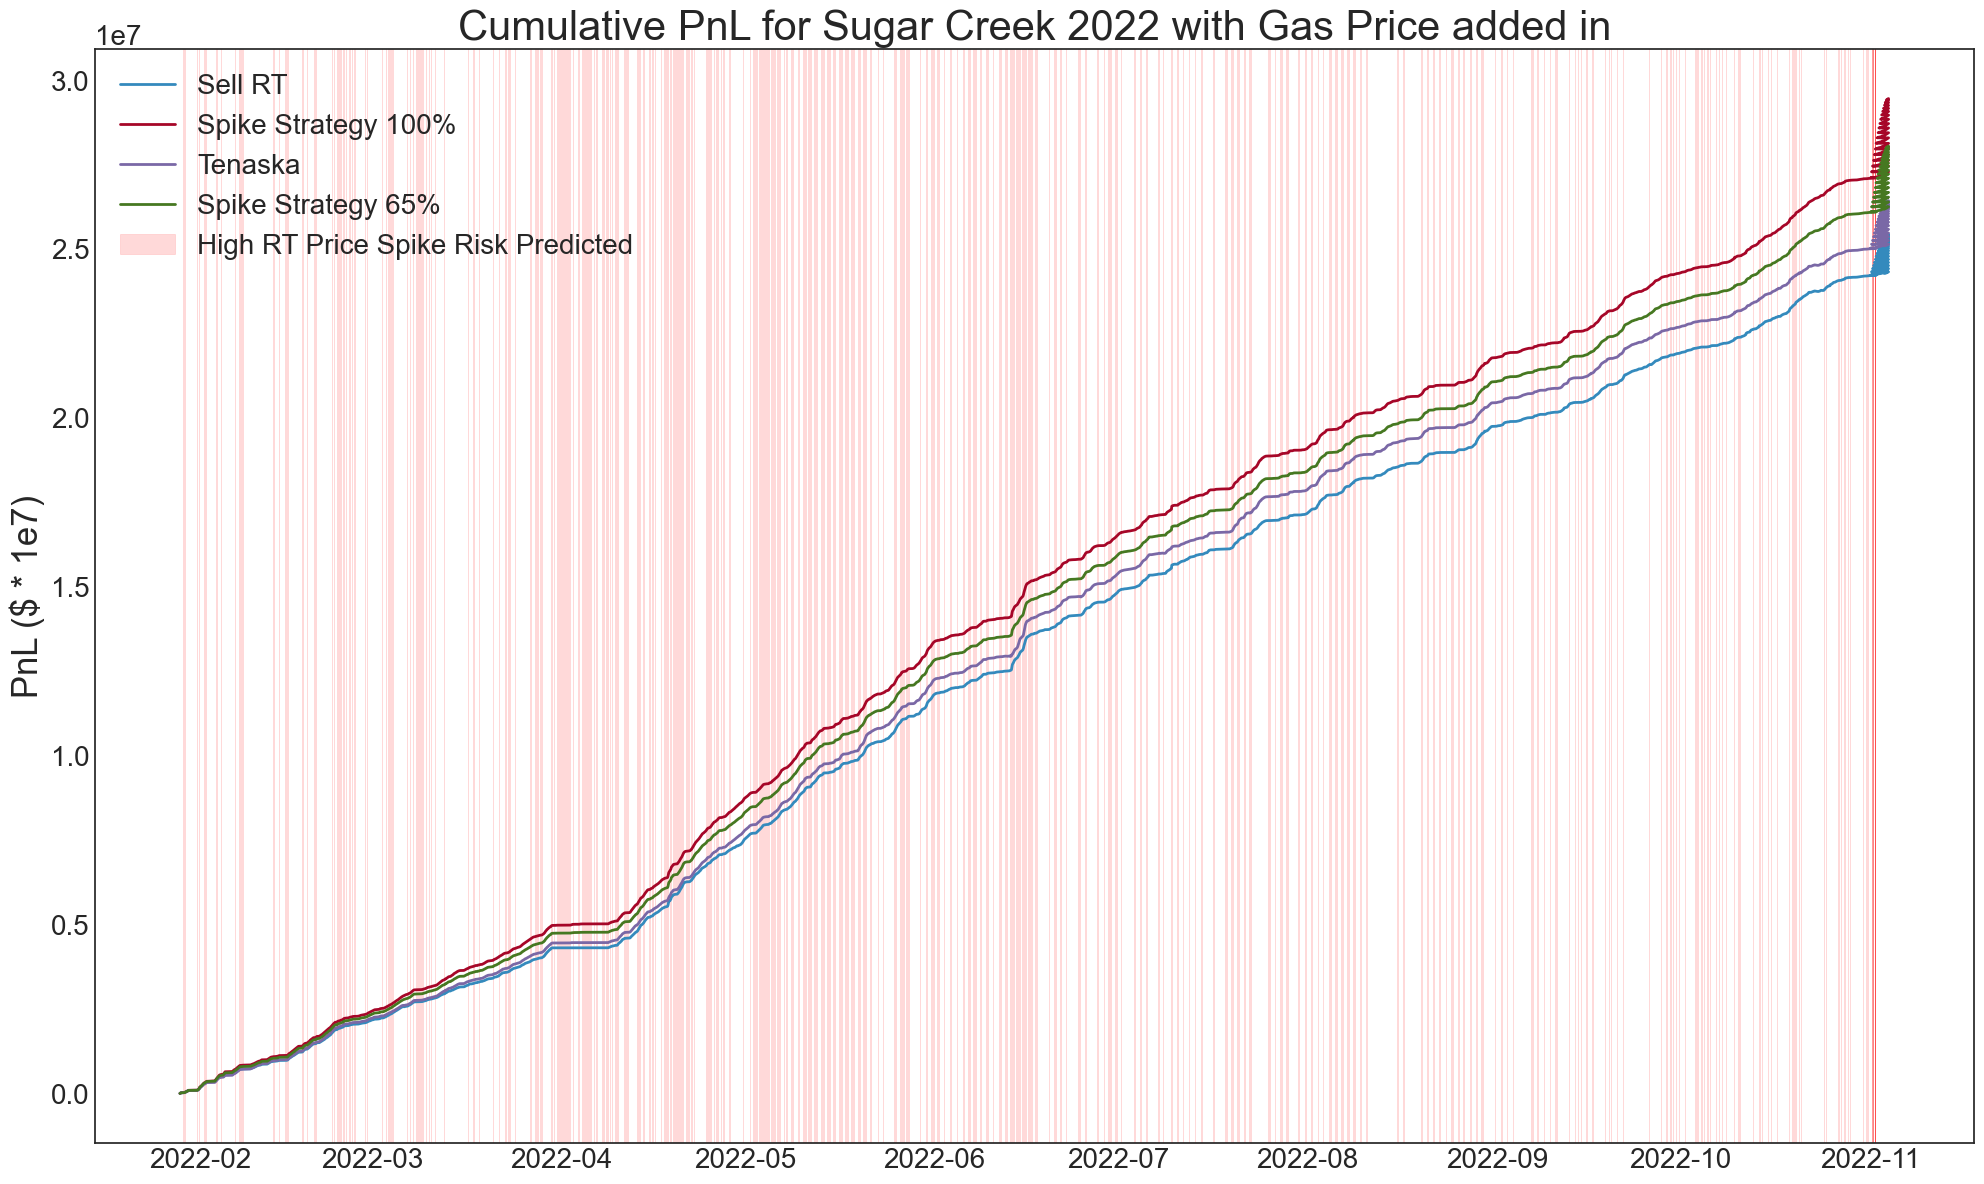

In [63]:
#cumulative PnL over the course of the whole year

df_hourly_A = pnl_sugar_creek_gas


plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(20,12),
                       tight_layout=True)

pnl1,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Sell RT']), label='Sell RT')

pnl2,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Spike Algorithm']), label='Spike Strategy 100%')

pnl3,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Tenaska']), label='Tenaska')

pnl4,=plt.plot(df_hourly_A['DATETIME'], np.cumsum(df_hourly_A['PnL: Spike Algorithm (65%)']), label='Spike Strategy 65%')

ax.xaxis.set_major_locator(md.MonthLocator())
#ax.xaxis.set_major_formatter(md.MonthFormatter('%b'))
ax.set_title("Cumulative PnL for Sugar Creek 2022 with Gas Price added in", fontsize='30')
ax.set_ylabel("PnL ($ * 1e7)", fontsize='25')

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spike Predicted']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[], loc='lower right', fontsize='20')
ax.legend(handles=[pnl1,pnl2, pnl3, pnl4, red_patch],loc='upper left', fontsize='20')
plt.rc('xtick', labelsize='20') 
plt.rc('ytick', labelsize='20') 
plt.show()

In [64]:
#The following table shows some comparative stats for PnL
#Percent Win is the amount of hours for which real time and predicted spikes matched up perfectly
#cumsum columns are the cumulative PnL up to the particular month
#the DELTA columns are the difference in cumulative PnL between the spike algorithm and Tenaska
pnl_sugar_creek_gas['COUNT']=1

pnl_sugar_creek_gas['WIN']=np.where((pnl_sugar_creek_gas['Spike Real']==pnl_sugar_creek_gas['Spike Predicted']), 1, 0)
pnl_sugar_creek_gas['DATE']= pd.to_datetime(pnl_sugar_creek_gas['DATETIME']).dt.date

pnl_sugar_creek_gas['MONTH'] = pd.to_datetime(pnl_sugar_creek_gas['DATE']).dt.to_period('M')
df_month_gas=pnl_sugar_creek_gas.groupby('MONTH').sum()

df_month_gas['PERCENT WIN']=df_month_gas['WIN']/df_month_gas['COUNT']*100
df_month_gas['cumsum Tenaska']=np.cumsum(df_month_gas['PnL: Tenaska'])
df_month_gas['cumsum Algo']=np.cumsum(df_month_gas['PnL: Spike Algorithm (65%)'])
df_month_gas['cumsum Algo 100']=np.cumsum(df_month_gas['PnL: Spike Algorithm'])
df_month_gas['DELTA 100%']=df_month_gas['cumsum Algo 100']-df_month_gas['cumsum Tenaska']
df_month_gas['DELTA 65%']=df_month_gas['cumsum Algo']-df_month_gas['cumsum Tenaska']
df_month_gas

C:\Users\katvo\AppData\Local\Temp\ipykernel_12228\286023723.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_gas=pnl_sugar_creek_gas.groupby('MONTH').sum()


,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,S1,COUNT,WIN,PERCENT WIN,cumsum Tenaska,cumsum Algo,cumsum Algo 100,DELTA 100%,DELTA 65%
MONTH,,,,,,,,,,,,,,,,,,,
2022-01,2239.94,2331.87,-10,0,1.874998e+05,1.728173e+05,1.998292e+05,1.955139e+05,22.636861,26.771536,24.779212,47,33,70.212766,1.728173e+05,1.955139e+05,1.998292e+05,2.701185e+04,2.269655e+04
2022-02,23644.78,22710.77,-152,-210,1.987664e+06,2.051602e+06,2.233168e+06,2.147241e+06,326.552807,245.956198,184.211680,524,412,78.625954,2.224419e+06,2.342755e+06,2.432997e+06,2.085777e+05,1.183360e+05
2022-03,29804.20,28110.31,-181,-325,2.138980e+06,2.233586e+06,2.551944e+06,2.407407e+06,450.099801,364.164818,261.553804,744,561,75.403226,4.458005e+06,4.750162e+06,4.984941e+06,5.269361e+05,2.921570e+05
2022-04,43879.75,42204.46,-176,43,3.218062e+06,3.333467e+06,3.761766e+06,3.571470e+06,345.076369,357.826438,369.271490,720,551,76.527778,7.791472e+06,8.321632e+06,8.746707e+06,9.552354e+05,5.301600e+05
2022-05,55642.62,54298.99,-67,29,4.285262e+06,4.465357e+06,4.631640e+06,4.510408e+06,339.207232,362.164921,356.774703,744,531,71.370968,1.225683e+07,1.283204e+07,1.337835e+07,1.121518e+06,5.752105e+05
2022-06,61462.78,59350.18,-149,-68,3.036773e+06,3.138791e+06,3.156039e+06,3.114296e+06,330.421739,301.443158,288.863698,720,562,78.055556,1.539562e+07,1.594634e+07,1.653439e+07,1.138766e+06,5.507153e+05
2022-07,63224.74,62052.05,-255,-186,2.330743e+06,2.487364e+06,2.572946e+06,2.488175e+06,386.469775,320.218749,227.822714,744,568,76.344086,1.788299e+07,1.843451e+07,1.910733e+07,1.224348e+06,5.515257e+05
2022-08,69232.35,70136.75,-194,-211,2.580670e+06,2.583472e+06,2.694663e+06,2.654766e+06,396.774106,270.498873,221.391535,744,594,79.838710,2.046646e+07,2.108928e+07,2.180200e+07,1.335539e+06,6.228193e+05
2022-09,53804.34,51086.92,-207,-349,2.167032e+06,2.242492e+06,2.502820e+06,2.385294e+06,426.818368,308.417567,171.358676,720,542,75.277778,2.270895e+07,2.347457e+07,2.430482e+07,1.595867e+06,7.656213e+05


Compare to the df_month table for the PnL without gas price. 
We see that adding in gas prices improves cumulative PnL over the year by around 200k. 

### How Much PnL do we lose during incorrect prediction hours?

In [68]:
#Table with wrong predictions 
bad_preds=pnl_sugar_creek_gas[(pnl_sugar_creek_gas['Spike Real']==1) & ((pnl_sugar_creek_gas['Spike Predicted']==0)|(pnl_sugar_creek_gas['Spike Predicted']==-1)) ]
bad_preds['DELTA 100% Spike - Tenaska']=bad_preds['PnL: Spike Algorithm']-bad_preds['PnL: Tenaska']
bad_preds['DELTA 100% Spike - Sell RT']= bad_preds['PnL: Spike Algorithm']-bad_preds['PnL: Sell RT']
bad_preds['DELTA 65% Spike - Tenaska']=bad_preds['PnL: Spike Algorithm (65%)']-bad_preds['PnL: Tenaska']
bad_preds['DELTA 65% Spike - Sell RT']= bad_preds['PnL: Spike Algorithm (65%)']-bad_preds['PnL: Sell RT']
bad_preds.drop(['COUNT', 'WIN', 'DATE', 'MONTH'],axis=1, inplace=True)
bad_preds.reset_index(inplace=True)
bad_preds.loc["Total"] = bad_preds.sum()
bad_preds

C:\Users\katvo\AppData\Local\Temp\ipykernel_12228\2032787428.py:9: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  bad_preds.loc["Total"] = bad_preds.sum()


,index,DATETIME,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,S1,DELTA 100% Spike - Tenaska,DELTA 100% Spike - Sell RT,DELTA 65% Spike - Tenaska,DELTA 65% Spike - Sell RT
0,188.0,2022-02-10 07:00:00,46.62,41.80,1.0,-1.0,2.967800e+03,3.206872e+03,3.446571e+03,3.279001e+03,0.564270,0.853333,0.353678,239.69860,478.77060,72.128890,311.200890
1,190.0,2022-02-10 09:00:00,53.54,41.49,1.0,-1.0,2.530849e+03,3.093584e+03,3.511899e+03,3.168531e+03,0.547930,0.900000,0.355243,418.31575,981.05075,74.947987,637.682987
2,199.0,2022-02-10 18:00:00,44.94,42.69,1.0,-1.0,1.152630e+03,1.223280e+03,1.336403e+03,1.272083e+03,0.471678,1.000000,0.417840,113.12325,183.77325,48.802612,119.452612
3,219.0,2022-02-12 10:00:00,42.13,35.74,1.0,-1.0,4.574649e+03,4.574649e+03,5.118182e+03,4.927945e+03,0.760000,0.526646,0.167532,543.53340,543.53340,353.296710,353.296710
4,220.0,2022-02-12 11:00:00,46.22,39.90,1.0,-1.0,4.508740e+03,4.508740e+03,4.925405e+03,4.779572e+03,0.623784,0.771160,0.229870,416.66496,416.66496,270.832224,270.832224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,7161.0,2022-11-03 20:00:00,42.82,43.58,1.0,-1.0,7.071683e+03,7.071683e+03,6.949026e+03,6.991956e+03,0.753815,0.774436,1.000000,-122.65716,-122.65716,-79.727154,-79.727154
348,7178.0,2022-11-03 20:00:00,42.82,43.58,1.0,-1.0,7.071683e+03,7.071683e+03,6.949026e+03,6.991956e+03,0.845614,0.581921,1.000000,-122.65716,-122.65716,-79.727154,-79.727154
349,7192.0,2022-11-03 20:00:00,42.82,43.58,1.0,-1.0,7.071683e+03,7.071683e+03,6.949026e+03,6.991956e+03,0.843429,0.751748,1.000000,-122.65716,-122.65716,-79.727154,-79.727154
350,7202.0,2022-11-03 20:00:00,42.82,43.58,1.0,-1.0,7.071683e+03,7.071683e+03,6.949026e+03,6.991956e+03,0.908907,0.467391,1.000000,-122.65716,-122.65716,-79.727154,-79.727154


- Bad Predictions occur for 352
- The PnL with Tenaska and 100% spike is about the same during these hours
- Using the 65% error on UL Forecast significantly improves PnL during these hours

In [67]:
#Table with hours with negative PnL
neg_pnl=pnl_sugar_creek_gas[(pnl_sugar_creek_gas['PnL: Spike Algorithm']<0) ]
neg_pnl['DELTA 100% Spike - Tenaska']=neg_pnl['PnL: Spike Algorithm']-neg_pnl['PnL: Tenaska']
neg_pnl['DELTA 100% Spike - Sell RT']= neg_pnl['PnL: Spike Algorithm']-neg_pnl['PnL: Sell RT']
neg_pnl['DELTA 65% Spike - Tenaska']=neg_pnl['PnL: Spike Algorithm (65%)']-neg_pnl['PnL: Tenaska']
neg_pnl['DELTA 65% Spike - Sell RT']= neg_pnl['PnL: Spike Algorithm (65%)']-neg_pnl['PnL: Sell RT']
neg_pnl.drop(['COUNT', 'WIN', 'DATE', 'MONTH'],axis=1, inplace=True)
neg_pnl.reset_index(inplace=True)
neg_pnl.loc["Total"] = neg_pnl.sum()
neg_pnl

C:\Users\katvo\AppData\Local\Temp\ipykernel_12228\1535841216.py:9: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  neg_pnl.loc["Total"] = neg_pnl.sum()


,index,DATETIME,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,S1,DELTA 100% Spike - Tenaska,DELTA 100% Spike - Sell RT,DELTA 65% Spike - Tenaska,DELTA 65% Spike - Sell RT
0,258.0,2022-02-14 17:00:00,45.44,48.49,-1.0,0.0,48.29604,48.29604,-5.06066,13.614185,0.365801,1.000000,0.318182,-53.35670,-53.35670,-34.681855,-34.681855
1,610.0,2022-03-02 15:00:00,28.87,31.29,-1.0,-1.0,312.93129,312.93129,-18.21909,97.683543,0.705196,0.669492,0.124365,-331.15038,-331.15038,-215.247747,-215.247747
2,611.0,2022-03-02 16:00:00,27.27,32.31,-1.0,-1.0,129.20769,129.20769,-458.07327,-252.524934,0.678685,0.711864,0.137056,-587.28096,-587.28096,-381.732624,-381.732624
3,616.0,2022-03-02 21:00:00,29.57,36.93,1.0,-1.0,553.95000,553.95000,-287.79112,6.818272,0.680806,0.717514,0.131980,-841.74112,-841.74112,-547.131728,-547.131728
4,981.0,2022-03-18 02:00:00,29.72,43.47,1.0,-1.0,0.00000,0.00000,-651.04875,-423.181687,0.425806,0.700000,0.493562,-651.04875,-651.04875,-423.181687,-423.181687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,6429.0,2022-10-31 02:00:00,37.90,39.17,-1.0,-1.0,0.00000,-17.64792,-10.26795,-6.674168,0.901879,0.192982,0.043174,7.37997,-10.26795,10.973753,-6.674168
98,6430.0,2022-10-31 03:00:00,36.91,39.21,-1.0,-1.0,0.07842,-32.82078,-22.22698,-14.420090,0.917537,0.167641,0.040840,10.59380,-22.30540,18.400690,-14.498510
99,6431.0,2022-10-31 04:00:00,36.10,37.57,-1.0,-1.0,9.54278,-13.53034,-14.29621,-5.952563,0.930063,0.140351,0.043174,-0.76587,-23.83899,7.577776,-15.495343
100,6432.0,2022-10-31 05:00:00,36.96,38.66,-1.0,-1.0,0.00000,-25.66320,-27.21870,-17.692155,0.902923,0.165692,0.058343,-1.55550,-27.21870,7.971045,-17.692155


- There are 102 hours with negative or zero PnL 
- Total PnL Loss is 17,177 
- Again we see that the 65% Error Strategy is useful during these hours

### Effect of Using Spiking Probabilities on Algorithm Percent win

In [69]:
#gradients were determined based on S1 values
pnl_sugar_creek['COUNT']=1
pnl_sugar_creek['Prob']=np.where(pnl_sugar_creek.S1<=0.33, -1, np.where(pnl_sugar_creek.S1<=0.66,0,1))
pnl_sugar_creek['Prob WIN']=np.where((pnl_sugar_creek['Spike Real']==pnl_sugar_creek['Prob']), 1, 0)
pnl_sugar_creek['WIN']=np.where((pnl_sugar_creek['Spike Real']==pnl_sugar_creek['Spike Predicted']), 1, 0)
pnl_sugar_creek['DATE']= pd.to_datetime(pnl_sugar_creek['DATETIME']).dt.date

pnl_sugar_creek['MONTH'] = pd.to_datetime(pnl_sugar_creek['DATE']).dt.to_period('M')
df_month=pnl_sugar_creek.groupby('MONTH').sum()

df_month['PERCENT WIN']=df_month['WIN']/df_month['COUNT']*100
df_month['PERCENT Prob WIN']=df_month['Prob WIN']/df_month['COUNT']*100
df_month['cumsum Tenaska']=np.cumsum(df_month['PnL: Tenaska'])
df_month['cumsum Algo']=np.cumsum(df_month['PnL: Spike Algorithm (65%)'])
df_month['cumsum Algo 100']=np.cumsum(df_month['PnL: Spike Algorithm'])
df_month['DELTA 100%']=df_month['cumsum Algo 100']-df_month['cumsum Tenaska']
df_month['DELTA 65%']=df_month['cumsum Algo']-df_month['cumsum Tenaska']
df_month

C:\Users\katvo\AppData\Local\Temp\ipykernel_12228\451009812.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month=pnl_sugar_creek.groupby('MONTH').sum()


,DALMP,RTLMP,Spike Real,Spike Predicted,PnL: Sell RT,PnL: Tenaska,PnL: Spike Algorithm,PnL: Spike Algorithm (65%),Sneg,S0,...,WIN,Prob,Prob WIN,PERCENT WIN,PERCENT Prob WIN,cumsum Tenaska,cumsum Algo,cumsum Algo 100,DELTA 100%,DELTA 65%
MONTH,,,,,,,,,,,,,,,,,,,,,
2022-02,1888.45,2069.28,-20,-26,1.060704e+05,1.039506e+05,1.268657e+05,1.195873e+05,32.338895,19.698361,...,42,-27,39,91.304348,84.782609,1.039506e+05,1.195873e+05,1.268657e+05,2.291512e+04,1.563676e+04
2022-03,29809.84,28096.55,-182,-308,2.135417e+06,2.230294e+06,2.540302e+06,2.398592e+06,447.627037,345.454225,...,573,-309,556,77.016129,74.731183,2.334245e+06,2.518180e+06,2.667168e+06,3.329228e+05,1.839348e+05
2022-04,43879.75,42204.46,-176,43,3.218062e+06,3.333467e+06,3.740868e+06,3.557886e+06,348.302181,368.137188,...,542,10,493,75.277778,68.472222,5.667712e+06,6.076066e+06,6.408036e+06,7.403241e+05,4.083541e+05
2022-05,55642.62,54298.99,-67,42,4.285262e+06,4.465357e+06,4.621974e+06,4.504125e+06,335.397122,378.338023,...,532,33,499,71.505376,67.069892,1.013307e+07,1.058019e+07,1.103001e+07,8.969404e+05,4.471213e+05
2022-06,61462.78,59350.18,-149,-80,3.036773e+06,3.138791e+06,3.175885e+06,3.127196e+06,328.228592,302.441908,...,545,-201,535,75.694444,74.305556,1.327186e+07,1.370739e+07,1.420589e+07,9.340347e+05,4.355262e+05
2022-07,63224.74,62052.05,-255,-212,2.330743e+06,2.487364e+06,2.621506e+06,2.519739e+06,388.025852,319.210062,...,574,-298,570,77.150538,76.612903,1.575922e+07,1.622713e+07,1.682740e+07,1.068176e+06,4.679007e+05
2022-08,69232.35,70136.75,-194,-197,2.580670e+06,2.583472e+06,2.694741e+06,2.654816e+06,387.873701,258.201766,...,596,-291,597,80.107527,80.241935,1.834270e+07,1.888194e+07,1.952214e+07,1.179445e+06,5.392447e+05
2022-09,53804.34,51086.92,-207,-368,2.167032e+06,2.242492e+06,2.505032e+06,2.386732e+06,430.992431,291.828228,...,532,-422,476,73.888889,66.111111,2.058519e+07,2.126867e+07,2.202717e+07,1.441985e+06,6.834844e+05
2022-10,35807.44,34907.73,-249,-338,2.288493e+06,2.307224e+06,2.805608e+06,2.624618e+06,426.406610,353.041030,...,565,-370,514,75.940860,69.086022,2.289241e+07,2.389329e+07,2.483278e+07,1.940369e+06,1.000879e+06


The probabilities had to be binned/discretized to get values for this metric, so this isn't a really good way of telling whether the probabilities are accurate.